### SBG389 PUI 2016 Final Notebook

This notebook contains the solution for the PUI_2016 final as per the requirements in 

https://github.com/fedhere/PUI2016_final/blob/master/PUI2016_final_instructions.ipynb

The work proposes an investigation of specific socioechonomic changes that happened in NYC over 10 years. The work on the notebook is divided as suggested on the proposal (A sequence of 13 steps that go from data wrangling to plotting, clustering, analysing and writing conclussions)

These steps are described bellow:

1) Retreive data on the number of businesses for NYC in 2010 and 2000 for every zip code.

2) Gather a zipcode shapefile and merge the number of businesses with the zipcode shapfile

3) Find the density of businesses (number of businesses by the area of the zipcode) and plot it in a choroplath for 2000 and 2010 (Will also show the difference in business density between 2000 and 2010 in a map)

4) Collect census data from the 2010 and 2000 census and extract the estimate (mean) age, population, and diversity of each census tract for all 5 NYC boroughs. The diversity (or lack thereof) can be measured by the fraction of white population.

5) Collect the income data by census tract from the income from American Fact Finder for the years 2010 and 2000 at the census tract level.

6) Merge the datasets for each year and show a the tables containing the relevant data: the features and whatever else you need to identify and plot the data.

7) Merge the df with the census tracts shapefile (see DATA and HINTS files) and display each of your features as a choropleth for both 2010 and 2000, and show the difference in the features as a third choroplath.

8) (OPTIONAL) Cluster the census tracts on these four features (using a Eucledian distance)

9) (OPTIONAL) Identify the census tracts that have changed cluster assignment (those that are now associated with a different group of census tracts) and show a choropleth of the clusters in 2010, 2000 and a choropleth of the cluster changes. (Once you get through this, you have done most of the heavy lifting! The rest isbuilding upon this work.)

10) Aggregate the census four features at the zipcode level and merge the zipcode dataframe

11) Repeat steps 7,8,9 at the zipcode level (NOT OPTIONAL AT THE ZIPCODE LEVEL) with the added feature (number of businesses).

12) Define a function that given a dataframe containing the relevant information and two cluster labels finds if the census tract changed cluster assignments from the first to the second label, and if so finds the individual features that are significantly different as measured by Pearson's correlation, plot those census tracts, and plot a histogram of the features that have significantly changed. Run your function for all label pairs (2 points, one for the identification of locations that changed cluster and one for the identifiation of the features that changed significantly).

13) Comment on the strength and weaknesses of this analysis, and on your findings (this is not the last step, but comments should be given throughout the notebook, and summarized here).

#### Dependencies:

This notebook uses two helper function to automate plottning related tasks. Ideally, these two functions will be defined in an external python module. I explicitely choosed to leave them in the notebook to make easier the review of the final (rather than jumping to other .py files)

These functions are

    generateCloropethMosaic
    
    analyzeCensusTractEvolution

In [94]:
# Standard imports wo wotk with data, graphs, APIs, etc.

# Compatibility with Python 3
from __future__ import print_function, division

import pylab as pl
import pandas as pd
import geopandas as gpd
import numpy as np
import os
import json
import requests
import urllib2
import urllib
import ast
from cStringIO import StringIO
from get_jsonparsed_data import get_jsonparsed_data
from pandas.tools.plotting import scatter_matrix
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats as stats
from scipy.interpolate import *
from sklearn.cluster import KMeans
from scipy.cluster.vq import whiten
import zipfile
from geopandas import GeoDataFrame
import pysal as ps
from fiona.crs import from_epsg
import matplotlib.colors as mcolors
import operator
from matplotlib.colors import ListedColormap    
from IPython.display import Image
from IPython.core.display import HTML 

# Horrible pandas plot bug
# http://stackoverflow.com/questions/33995707/attributeerror-unknown-property-color-cycle
#matplotlib.style.use('ggplot')

#loading rcParams from JSON template (created from Federica's fbb_matplotlibrc.json)
url = 'https://s3.amazonaws.com/sb-public/sbg389_matplotlibrc.json'
resp = requests.get(url=url)
data = json.loads(resp.text)
# update the rcParams object
pl.rcParams.update(data)

%pylab inline

Populating the interactive namespace from numpy and matplotlib


/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['polyint', 'griddata', 'insert']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


### 1. Retreive data on the number of businesses for NYC in 2010 and 2000 for every zip code.

In [4]:
# Get the PUIData path
puidata = os.getenv ('PUIDATA')

# Download the data from the census FTP site for the years 2000 and 2010
# Will run it once and comment to avoid rerun while working on the notebook
# Uncomment to get data

#if not os.path.isfile(puidata + "/zbp00totals.zip"):
#    !wget ftp://ftp.census.gov/Econ2001_And_Earlier/CBP_CSV/zbp00totals.zip

#if not os.path.isfile(puidata + "/zbp10totals.zip"):
#    !wget ftp://ftp.census.gov/econ2010/CBP_CSV/zbp10totals.zip

# Move data to puidata
#!mv *.zip $PUIDATA

In [5]:
# Load the data directly from the zips into pandas dataframe

zf = zipfile.ZipFile(puidata + '/zbp00totals.zip')
dfBusiness2000 = pd.read_csv(zf.open('zbp00totals.zip'.replace('.zip','.txt')))

zf = zipfile.ZipFile(puidata + '/zbp10totals.zip')
dfBusiness2010 = pd.read_csv(zf.open('zbp10totals.zip'.replace('.zip','.txt')))

In [6]:
# Take a quick look at the data on the dataframe for 2000
dfBusiness2000.head()

ZIP            NAME EMPFLAG   EMP    QP1      AP  EST
0   501  HOLTSVILLE, NY       A     0      0       0    1
1  1001      AGAWAM, MA     NaN  8042  59833  259661  493
2  1002     AMHERST, MA     NaN  6547  36719  169658  563
3  1003     AMHERST, MA     NaN    82    308    2482   13
4  1004     AMHERST, MA     NaN   717   2049    5826   48

In [7]:
# Take a quick look at the data on the dataframe for 2010
dfBusiness2010.head()

zip            name empflag emp_nf    emp qp1_nf    qp1 ap_nf      ap  \
0   501  HOLTSVILLE, NY       A      D      0      D      0     D       0   
1  1001      AGAWAM, MA     NaN      G   9185      G  70693     G  314508   
2  1002     AMHERST, MA     NaN      G  15633      G  82069     G  351589   
3  1003     AMHERST, MA     NaN      G    168      H   1297     H    5761   
4  1004     AMHERST, MA     NaN      H    189      H   1710     H    7241   

   est        city stabbr   cty_name  
0    2  HOLTSVILLE     NY    SUFFOLK  
1  448      AGAWAM     MA    HAMPDEN  
2  570     AMHERST     MA  HAMPSHIRE  
3   16     AMHERST     MA  HAMPSHIRE  
4   21     AMHERST     MA  HAMPSHIRE

Upon a quick review of both dataframes containing the 2000 and 2010 data we observe that there were changes on the file schema (2010 has a richer schema, with aditional information). We also see that the number of businesses has changed (which was expected after a decade), this will be one of the elements to consider in the next data wrangling steps

### 2. Gather a zipcode shapefile and merge the number of businesses with the zipcode shapfile

In [8]:
# Download a geojson file containing the zip codes
# from fbb git (the original datasource is unrelaiable, we will use the copy)

url = ('https://raw.githubusercontent.com/fedhere/PUI2016_fb55/' +
       'master/HW11_fb55/nyc-zip-code-tabulation-areas-polygons.geojson')

if not os.path.isfile(puidata + "/nyc-zip-code-tabulation-areas-polygons.geojson"):
    os.system("curl -o nyc-zip-code-tabulation-areas-polygons.geojson " + url)
    os.system("mv nyc-zip-code-tabulation-areas-polygons.geojson " + os.getenv("PUIDATA"))


In [9]:
# Load the geojson file with the zip codes into a geodataframe

geoZips = GeoDataFrame.from_file( os.getenv("PUIDATA") + 
                                 '/nyc-zip-code-tabulation-areas-polygons.geojson')

geoZips.rename(columns={'postalCode': 'zip'}, inplace=True)
geoZips = geoZips[['PO_NAME', 'STATE', 'Shape_Area',
                     'Shape_Leng', 'borough', 'geometry','zip']]

# Quick exploration of the data
geoZips.head()

PO_NAME STATE    Shape_Area    Shape_Leng borough  \
0  Jackson Heights    NY  2.016328e+07  20624.692317  Queens   
1        Glen Oaks    NY  2.260653e+07  23002.816039  Queens   
2    New Hyde Park    NY  6.269333e+06  15749.161511  Queens   
3        Bellerose    NY  4.941836e+07  35932.810639  Queens   
4    Fresh Meadows    NY  6.938587e+07  38693.565676  Queens   

                                            geometry    zip  
0  POLYGON ((-73.86942457284175 40.74915687096787...  11372  
1  POLYGON ((-73.71068374074007 40.75004039450917...  11004  
2  POLYGON ((-73.70098278625547 40.73889569923034...  11040  
3  POLYGON ((-73.72270447144122 40.75373371438336...  11426  
4  POLYGON ((-73.81088634744755 40.72717187575918...  11365

In [10]:
# Normalize the type and name of the zip column on all dataframes and merge

dfBusiness2010.zip = dfBusiness2010.zip.astype(str)
dfBusiness2000.rename(columns={'ZIP': 'zip'}, inplace=True)
dfBusiness2000.zip = dfBusiness2000.zip.astype(str)

geoZips.zip = geoZips.zip.astype(str)

geoDfBusiness2000 = pd.merge(geoZips, dfBusiness2000, on=['zip'])
geoDfBusiness2010 = pd.merge(geoZips, dfBusiness2010, on=['zip'])

### 3) Find the density of businesses (number of businesses by the area of the zipcode) and plot it in a choroplath for 2000 and 2010 (Will also show the difference in business density between 2000 and 2010 in a map)

In [11]:
print ('Total number of rows in geoDfBusiness2000: ' + str (len(geoDfBusiness2000)))
geoDfBusiness2000.head()

Total number of rows in geoDfBusiness2000: 253


PO_NAME STATE    Shape_Area    Shape_Leng borough  \
0  Jackson Heights    NY  2.016328e+07  20624.692317  Queens   
1        Glen Oaks    NY  2.260653e+07  23002.816039  Queens   
2    New Hyde Park    NY  6.269333e+06  15749.161511  Queens   
3        Bellerose    NY  4.941836e+07  35932.810639  Queens   
4    Fresh Meadows    NY  6.938587e+07  38693.565676  Queens   

                                            geometry    zip  \
0  POLYGON ((-73.86942457284175 40.74915687096787...  11372   
1  POLYGON ((-73.71068374074007 40.75004039450917...  11004   
2  POLYGON ((-73.70098278625547 40.73889569923034...  11040   
3  POLYGON ((-73.72270447144122 40.75373371438336...  11426   
4  POLYGON ((-73.81088634744755 40.72717187575918...  11365   

                  NAME EMPFLAG    EMP     QP1      AP   EST  
0  JACKSON HEIGHTS, NY     NaN   6817   36731  162841  1409  
1        GLEN OAKS, NY     NaN   2619   20334   81991   189  
2    NEW HYDE PARK, NY     NaN  22333  212336  905713  1350  
3        BELLEROSE, NY     NaN   2410   14163   58590   213  
4    FRESH MEADOWS, NY     NaN   6147   46601  216162   553

In [12]:
print ('Total number of rows in geoDfBusiness2010: ' + str (len(geoDfBusiness2010)))
geoDfBusiness2010.head()

Total number of rows in geoDfBusiness2010: 254


PO_NAME STATE    Shape_Area    Shape_Leng borough  \
0  Jackson Heights    NY  2.016328e+07  20624.692317  Queens   
1        Glen Oaks    NY  2.260653e+07  23002.816039  Queens   
2    New Hyde Park    NY  6.269333e+06  15749.161511  Queens   
3        Bellerose    NY  4.941836e+07  35932.810639  Queens   
4    Fresh Meadows    NY  6.938587e+07  38693.565676  Queens   

                                            geometry    zip  \
0  POLYGON ((-73.86942457284175 40.74915687096787...  11372   
1  POLYGON ((-73.71068374074007 40.75004039450917...  11004   
2  POLYGON ((-73.70098278625547 40.73889569923034...  11040   
3  POLYGON ((-73.72270447144122 40.75373371438336...  11426   
4  POLYGON ((-73.81088634744755 40.72717187575918...  11365   

                  name empflag emp_nf    emp qp1_nf     qp1 ap_nf       ap  \
0  JACKSON HEIGHTS, NY     NaN      G   7676      G   53202     G   232448   
1        GLEN OAKS, NY     NaN      H   2662      H   27391     H   112122   
2    NEW HYDE PARK, NY     NaN      H  21724      H  275537     H  1203113   
3        BELLEROSE, NY     NaN      H   1644      H   12110     H    52068   
4    FRESH MEADOWS, NY     NaN      G   7173      G   74371     G   313518   

    est             city stabbr cty_name  
0  1629  JACKSON HEIGHTS     NY   QUEENS  
1   229        GLEN OAKS     NY   QUEENS  
2  1494    NEW HYDE PARK     NY   NASSAU  
3   248        BELLEROSE     NY   QUEENS  
4   643    FRESH MEADOWS     NY   QUEENS

In [13]:
# Set the coordinate system for the geodataframes
# epsg=4326: lat/on | 26918: NAD83/UTM zone 18N | epsg=2263 is US feet
# The dataframes have lat lon for the poliygons, so will set 4326
geoDfBusiness2000.crs = from_epsg(4326) 
geoDfBusiness2010.crs = from_epsg(4326)

# Get the area calculation for the zip by using the epsg 2263 (US Feet) converting from ft2 to mi2
geoDfBusiness2000['zipArea']=geoDfBusiness2000.to_crs(epsg=2263).geometry.area/(2.788*10**7) 
geoDfBusiness2010['zipArea']=geoDfBusiness2010.to_crs(epsg=2263).geometry.area/(2.788*10**7)

# geoDfBusiness2000['zipArea']=geoDfBusiness2000.to_crs(epsg=2263).geometry.area
# geoDfBusiness2010['zipArea']=geoDfBusiness2010.to_crs(epsg=2263).geometry.area

# Calculate the bsuiness density (bizDensity) by dividing the number of business by the area of the zip
geoDfBusiness2000['bizDensity']=geoDfBusiness2000.EST/geoDfBusiness2000.zipArea
geoDfBusiness2010['bizDensity']=geoDfBusiness2010.est/geoDfBusiness2010.zipArea

In [14]:
# Verify the area calculations (we know NYC has aprox 300 Square Miles)
print('The total sum of zip areas for the 2000 df is ' + str(geoDfBusiness2000.zipArea.sum()))
print('The total sum of zip areas for the 2010 df is ' + str(geoDfBusiness2010.zipArea.sum()) + '\n')
print('The difference can be attributed to the difference on the available data per zip' + \
     ' that was observer during the data exploration')


The total sum of zip areas for the 2000 df is 298.19845256
The total sum of zip areas for the 2010 df is 298.749047815

The difference can be attributed to the difference on the available data per zip that was observer during the data exploration


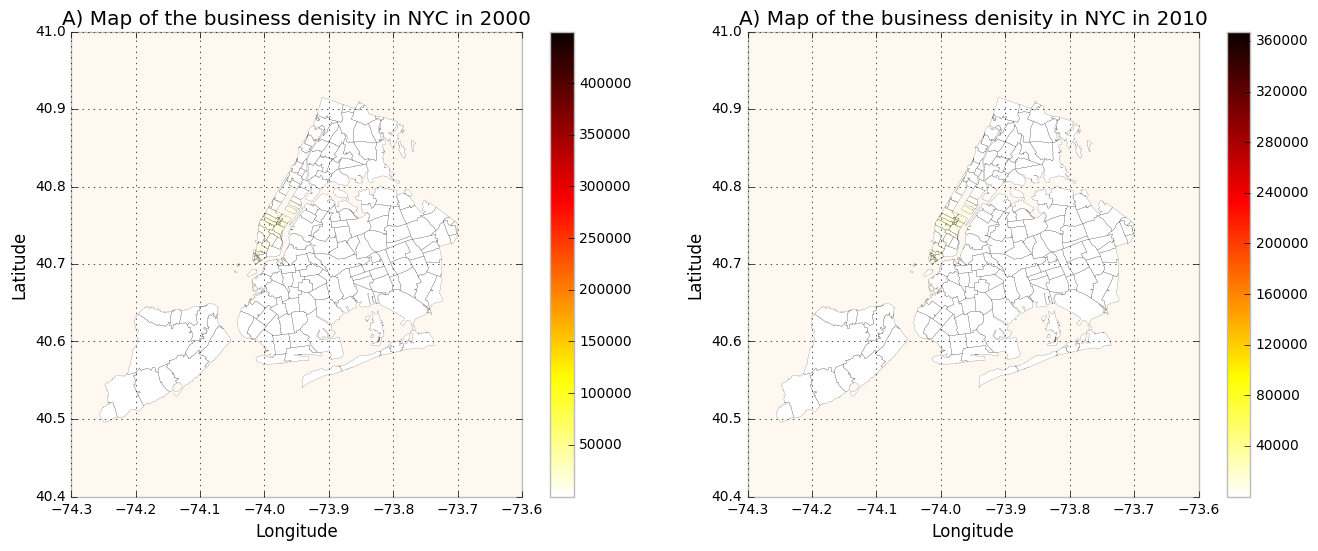

In [15]:
# Plot the cloroplaths for 2000 and 2010 represeing the business density

fig, (ax1, ax2) = pl.subplots(nrows=1, ncols=2, figsize=(16, 6))

# 2000 plot
geoDfBusiness2000.plot(column='bizDensity', cmap='hot_r', alpha=1,
                        linewidth=0.1, ax=ax1)
ax1.set_title('A) Map of the business denisity in NYC in 2000')
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')

normalize = mcolors.Normalize(vmin=geoDfBusiness2000.bizDensity.min(),
                              vmax=geoDfBusiness2000.bizDensity.max())
colormap = cm.hot_r
scalarmappaple = cm.ScalarMappable(norm=normalize, cmap=colormap)
scalarmappaple.set_array(geoDfBusiness2000.bizDensity)
pl.colorbar(scalarmappaple, ax=ax1)

# 2010 plot
geoDfBusiness2000.plot(column='bizDensity', cmap='hot_r', alpha=1,
                        linewidth=0.1, ax=ax2)
ax2.set_title('A) Map of the business denisity in NYC in 2010')
ax2.set_xlabel('Longitude')
ax2.set_ylabel('Latitude')

normalize = mcolors.Normalize(vmin=geoDfBusiness2010.bizDensity.min(),
                              vmax=geoDfBusiness2010.bizDensity.max())
colormap = cm.hot_r
scalarmappaple = cm.ScalarMappable(norm=normalize, cmap=colormap)
scalarmappaple.set_array(geoDfBusiness2010.bizDensity)
pl.colorbar(scalarmappaple, ax=ax2)

Figure I. Comparison of Business Desnity (Number of businesses per square mile in NYC) between 2000 ad 2010. Both maps show the highest concentration of businesses on a reduced number of zip codes, mostly located in the area of midtwon manhattan')

In [16]:
# The cloromaps dont look very appealing. 
# Will get a sense of how distant the more busidense and less business dense zips are
# Will do it with 2010 only to get a sense

print ('The 2010 business density for zips has a mean of: ' 
       + str(geoDfBusiness2010['bizDensity'].mean())
       + ' and a standard deviation of ' + str (geoDfBusiness2010['bizDensity'].std()))
print('\n')

maxZip = (geoDfBusiness2010.ix[geoDfBusiness2010['bizDensity'].idxmax()]['zip'])
maxEst = (geoDfBusiness2010.ix[geoDfBusiness2010['bizDensity'].idxmax()]['est'])
maxZipArea = (geoDfBusiness2010.ix[geoDfBusiness2010['bizDensity'].idxmax()]['zipArea'])
maxBzDensity = (geoDfBusiness2010.ix[geoDfBusiness2010['bizDensity'].idxmax()]['bizDensity'])

print ('The zipcode in 2010 with more Business Density was: ' + str(maxZip))
print (str(maxZip) + ' had ' + str (maxEst) + ' Business' + ' in an area of : ' + 
       str (maxZipArea) + ' square miles, which represents ' +
       str (maxBzDensity) + ' business per square mile \n' )

minZip = (geoDfBusiness2010.ix[geoDfBusiness2010['bizDensity'].idxmin()]['zip'])
minEst = (geoDfBusiness2010.ix[geoDfBusiness2010['bizDensity'].idxmin()]['est'])
minZipArea = (geoDfBusiness2010.ix[geoDfBusiness2010['bizDensity'].idxmin()]['zipArea'])
minBizDensity = (geoDfBusiness2010.ix[geoDfBusiness2010['bizDensity'].idxmin()]['bizDensity'])
 
print ('The zipcode in 2010 with less Business Density was: ' + str(minZip))
print (str(minZip) + ' had ' + str (minEst) + ' Business' + ' and a density of: ' + 
       str (minBizDensity) + ' business per square mile')

#print (geoDfBusiness2010[['zip','est']][(geoDfBusiness2010.zip == '10123')])
#print (geoDfBusiness2000[['zip','EST']][(geoDfBusiness2000.zip == '10123')])

The 2010 business density for zips has a mean of: 17952.4958762 and a standard deviation of 48353.8215605


The zipcode in 2010 with more Business Density was: 10123
10123 had 214 Business in an area of : 0.000582302999645 square miles, which represents 367506.264145 business per square mile 

The zipcode in 2010 with less Business Density was: 11251
11251 had 3 Business and a density of: 8.04400479529 business per square mile


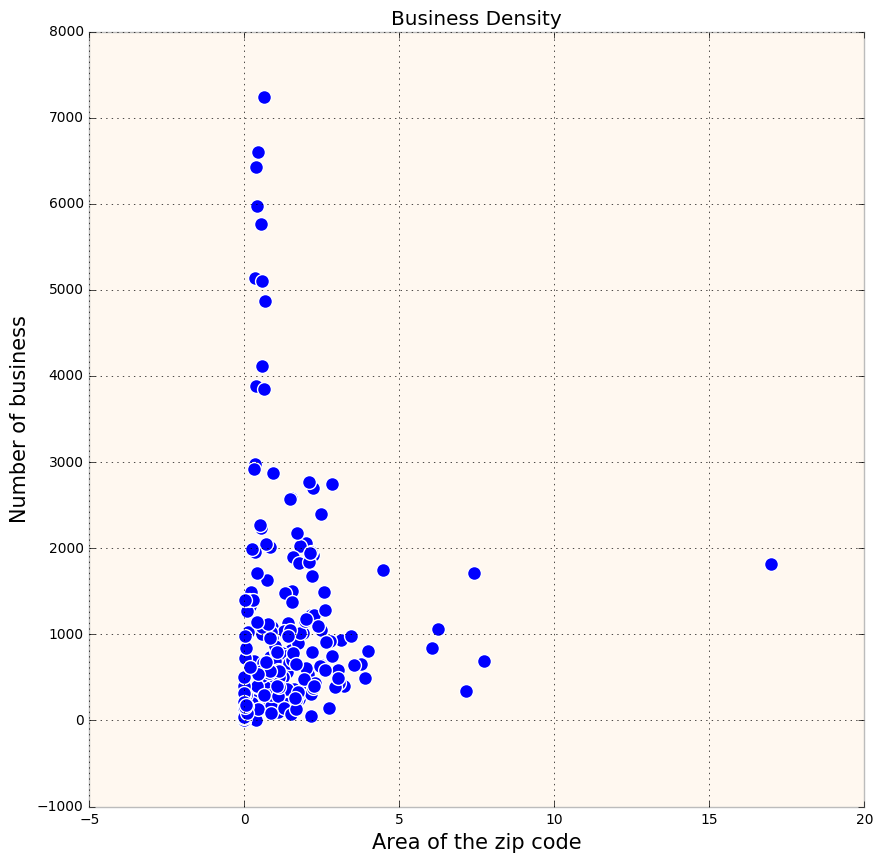

In [17]:
# Further exploration of this uneven distribution
# Visually represent density by zip to see if there are outliers

pl.figure(figsize=(10,10))
pl.scatter(geoDfBusiness2010.zipArea, geoDfBusiness2010.est, s=100)
pl.xlabel("Area of the zip code", fontsize=15)
pl.ylabel("Number of business", fontsize=15)
pl.title("Business Density")

Figure II. Scatterplot presenting the business density (number of business per area of the zip code). Most of the zip codes have less than five square miles and 1000 businesses, but here are a significant number of zips with high number of businesses (more than 2000) and small areas (closer to the 0 on the x axis). This explains the predominant lighter colors on the previous figure.

In [18]:
# A more meaningfull plot to gain insights on the socioechonomic changes that happened in NYC over 10 years
# (Main focus of this work) will be to plot the changes in business density between 2000 and 2010 in a map

# Create year specific density columns on 2000 and 2010 to merge both on a single dataframe
geoDfBusiness2000['bizDensity2000'] = geoDfBusiness2000['bizDensity']
geoDfBusiness2010['bizDensity2010'] = geoDfBusiness2010['bizDensity']

geoDfBusiness = pd.merge(geoDfBusiness2000, geoDfBusiness2010, on=['zip'])
geoDfBusiness['bizDensityDelta'] = geoDfBusiness['bizDensity2010'] - geoDfBusiness['bizDensity2000']
geoDfBusiness['geometry'] = geoDfBusiness['geometry_x']  

In [19]:
geoDfBusiness[['zip','bizDensity2010','bizDensity2000','bizDensityDelta']].head()

zip  bizDensity2010  bizDensity2000  bizDensityDelta
0  11372     2249.884432     1946.032637       303.851796
1  11004      282.183941      232.894169        49.289771
2  11040     6651.395266     6010.296927       641.098339
3  11426      139.992284      120.235308        19.756975
4  11365      258.205900      222.065105        36.140795

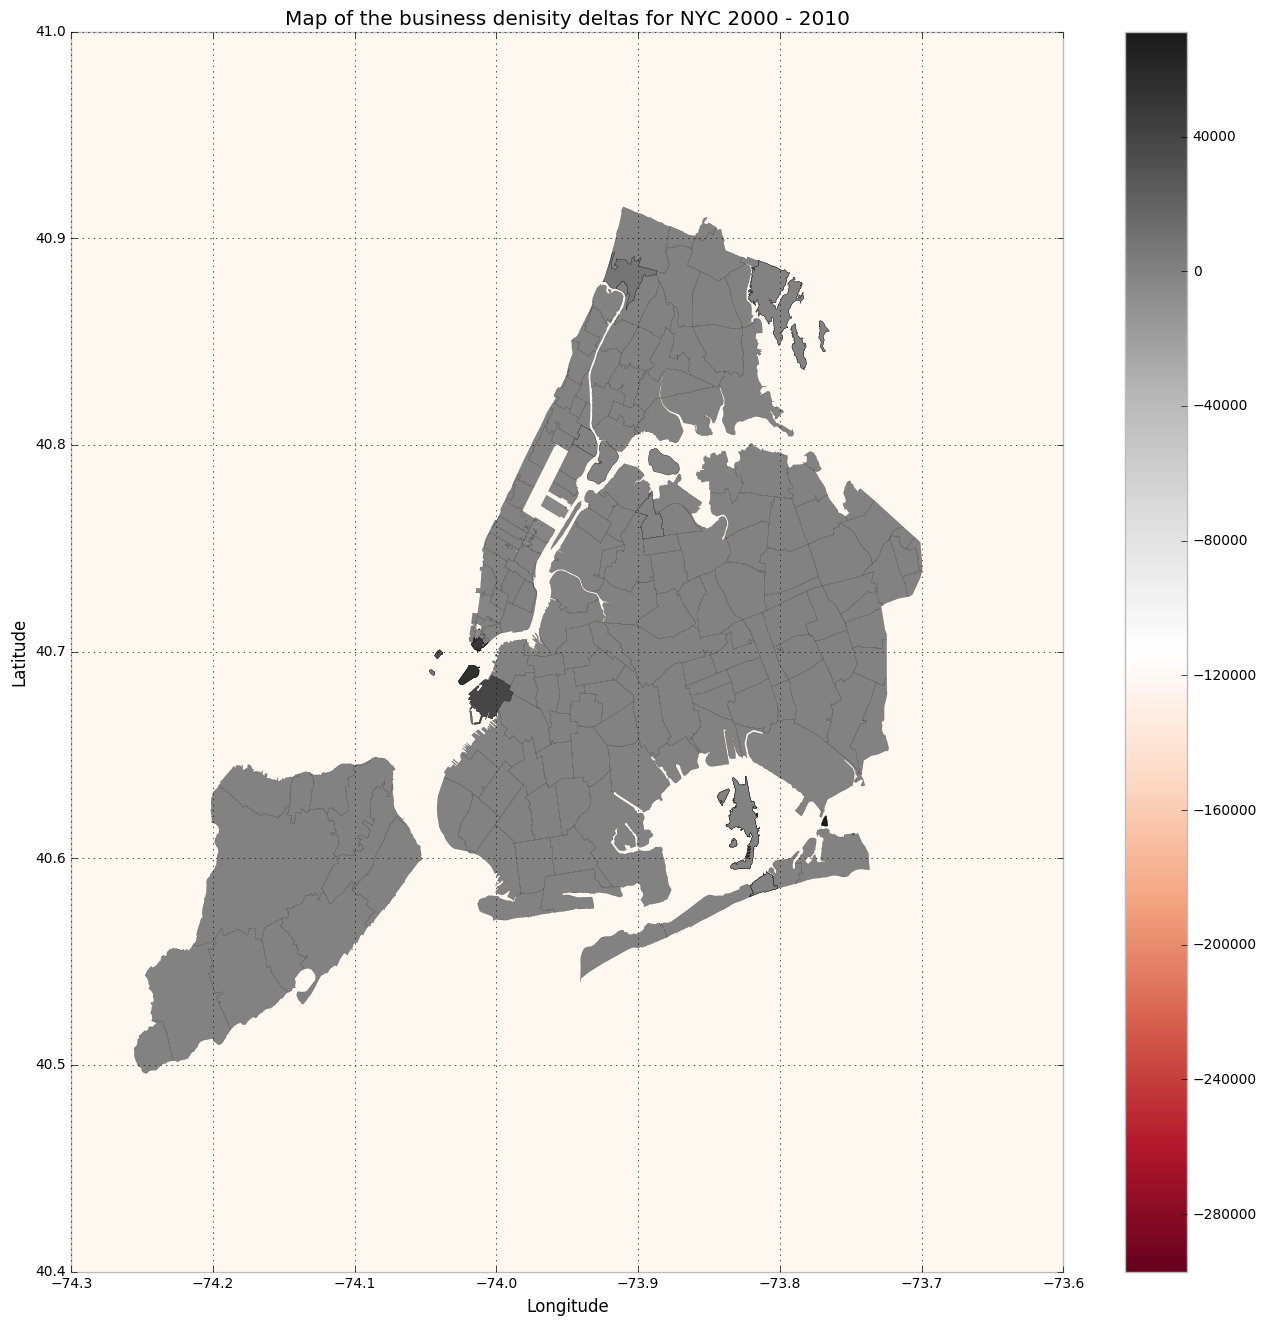

In [20]:
#Plot of the Biz density delta

fig, (ax1) = pl.subplots(nrows=1, ncols=1, figsize=(16, 16))

geoDfBusiness.plot(column='bizDensityDelta', cmap='RdGy', alpha=1,
                        linewidth=0.1, ax=ax1)
ax1.set_title('Map of the business denisity deltas for NYC 2000 - 2010')
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')

normalize = mcolors.Normalize(vmin=geoDfBusiness.bizDensityDelta.min(),
                              vmax=geoDfBusiness.bizDensityDelta.max())
colormap = cm.RdGy
scalarmappaple = cm.ScalarMappable(norm=normalize, cmap=colormap)
scalarmappaple.set_array(geoDfBusiness.bizDensityDelta)
pl.colorbar(scalarmappaple, ax=ax1)

Figure III. Changes on the business density between 2000 ad 2010. This plot uses a divergent colormap to indicate positive and negative changes on the density of business between 2000 and 2010. The maps shows an extreme concentration of changes in business density (both positive and negative) on a relatively a number of zip codes.

In [21]:
# Again the heatmap is not appealing.
# Will explore some of values the and find traces :

print ('The Zip code with more business density positive changes is:')
print (geoDfBusiness.ix[geoDfBusiness['bizDensityDelta'].idxmax()]\
[['zip','bizDensity2010','bizDensity2000','bizDensityDelta','zipArea_x','EST','est']])

print ('\n')

print ('The Zip code with more business density negative changes is:')
print (geoDfBusiness.ix[geoDfBusiness['bizDensityDelta'].idxmin()]\
[['zip','bizDensity2010','bizDensity2000','bizDensityDelta','zipArea_x','EST','est']])

#pl.figure(figsize=(10,10))
#pl.scatter(geoDfBusiness.zipArea_x, geoDfBusiness.bizDensityDelta, s=100)
#pl.xlabel("Area of the zip code", fontsize=15)
#pl.ylabel("Biz Delta", fontsize=15)
#pl.title('Business Density Deltas') ;

The Zip code with more business density positive changes is:
zip                    11096
bizDensity2010       76095.8
bizDensity2000        4887.4
bizDensityDelta      71208.4
zipArea_x          0.0544256
EST                      266
est                      300
Name: 215, dtype: object


The Zip code with more business density negative changes is:
zip                     10080
bizDensity2010        9077.95
bizDensity2000         306108
bizDensityDelta       -297030
zipArea_x          0.00275393
EST                       843
est                        25
Name: 283, dtype: object


The analysis of the maximum and minimum business density changes does not seem to reveal problems with the data

The zipp 11096 (inwood) has increased its numbe of business from 266 to 300, having an area of only 0.054 square miles which gave it a business density increase of 71208.4 per square mile.

The zip 10080 (a small area on the manhattan financial district between the hudson river and west street) has decreased its business on the period from 843 to 25. This zip has an area even smaller than inwood (0.0027 square miles) which makes the change represents a bsuiness density decrease of 297030 business per square mile. This is clearly an extreme case, which deserved further investigation: after locating exactly the zip on a map and reviewind the constructions on it, we found that the zip delimited a part of the world trade center complex that hosted business and that was affected during the sept 9 2011 attacks.

An approach to get a nicer heatmap for the changes might be remove some of the extreme values (outliers). Will visualize again and try to identify those outliers. Other approach to deal with extremes variations on the data, like using the Log10 of the values, will not work in this case, as this data contains both negative and positive numbers.

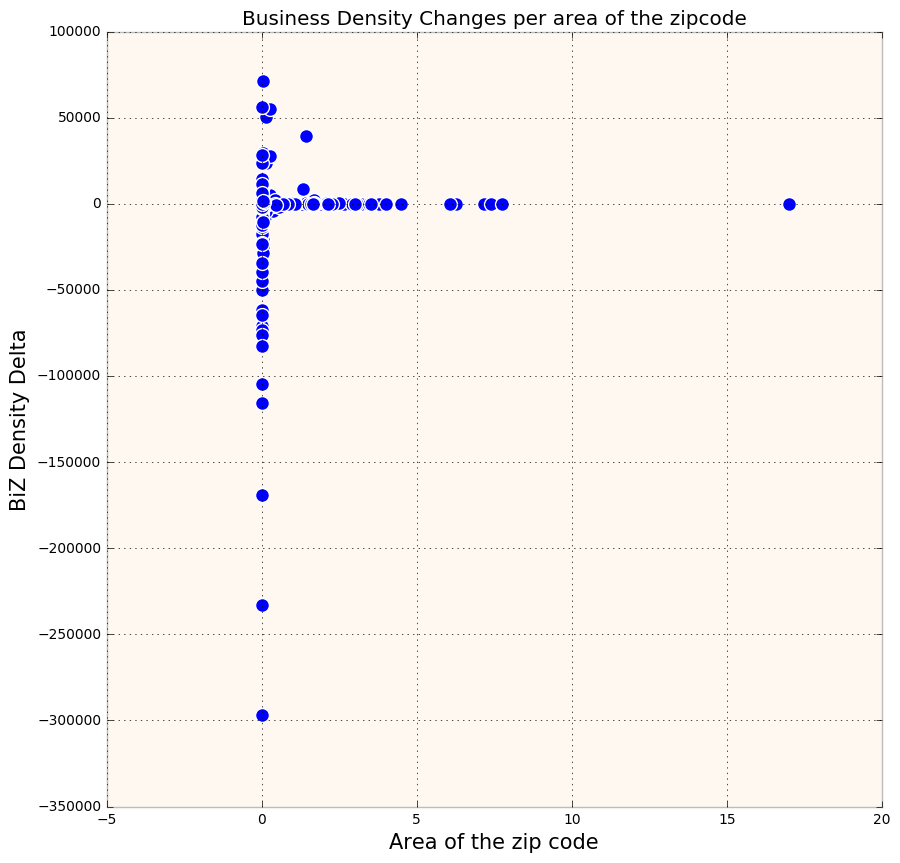

In [22]:
# Further exploring this uneven distribution
# Visually represent density by zip to see if there are outliers

pl.figure(figsize=(10,10))
pl.scatter(geoDfBusiness.zipArea_x, geoDfBusiness.bizDensityDelta, s=100)
pl.xlabel("Area of the zip code", fontsize=15)
pl.ylabel("BiZ Density Delta", fontsize=15)
pl.title('Business Density Changes per area of the zipcode') ;


Figure IV. Scatterplot presenting the business density deltas per zip code area. This plot gives us a general idea of the outliers for this dataset that will inform the next plot refinement .

In [23]:
# Plot of the Biz density delta without outliers, attempting several, starting form the graph above
# and checking on the colormap for the total surface that "dissapeared"
# This will be an interative process and the value used bellow on the broadcast to filter the outliers
# Will be informed by these two plots.

tempDf = geoDfBusiness[['geometry','bizDensityDelta','zipArea_x']][(geoDfBusiness.bizDensityDelta >= -1500)\
                                                       & (geoDfBusiness.bizDensityDelta <= 1500)]

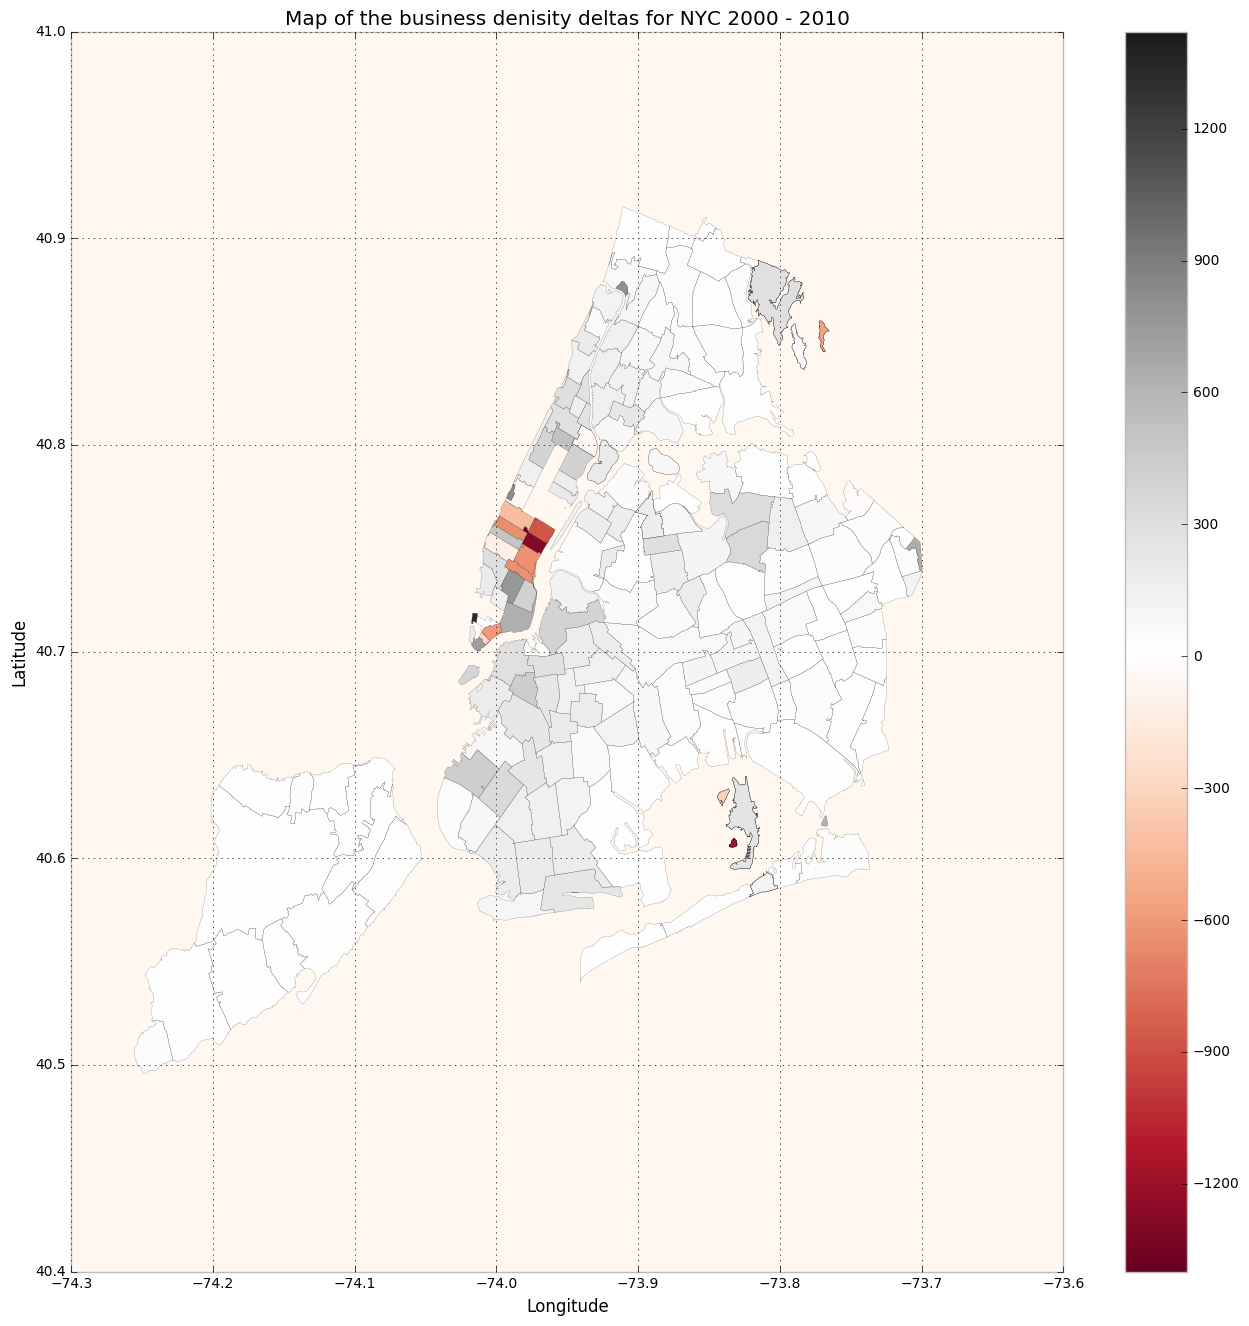

In [24]:
fig, (ax1) = pl.subplots(nrows=1, ncols=1, figsize=(16, 16))

tempDf.plot(column='bizDensityDelta', cmap='RdGy', alpha=1,
                        linewidth=0.1, ax=ax1)
ax1.set_title('Map of the business denisity deltas for NYC 2000 - 2010')
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')

normalize = mcolors.Normalize(vmin=tempDf.bizDensityDelta.min(),
                              vmax=tempDf.bizDensityDelta.max())
colormap = cm.RdGy
scalarmappaple = cm.ScalarMappable(norm=normalize, cmap=colormap)
scalarmappaple.set_array(tempDf.bizDensityDelta)
pl.colorbar(scalarmappaple, ax=ax1)

Figure IV. This Business Demsity Delta colormap considers only zips with an absolute density delta of less than 1500 business per square mile. This criteria helps us getting a better idea of the general evolutionof the whole NYC city in terms of the creation and elimination of business by zip code. The removed outlier zips (as seen on the map) only represents a small surface. From this new colormap, we can observe that the borough with more variations is manhattan, which has both noticable increases and decreases of business on most of its zip codes, including the most extreme of both variations. Brooklyn, Queens and the Bronx appear to have only increases, while staten island shows close to 0 variations on the business density.

###  4) Collect census data from the 2010 and 2000 census and extract the estimate (mean) age, population, and diversity of each census tract for all 5 NYC boroughs. The diversity (or lack thereof) will be measured by the fraction of white population.

### 5) Collect the income data by census tract from the income from American Fact Finder for the years 2010 and 2000 at the census tract level.

### 6) Merge the datasets for each year and show a the tables containing the relevant data: the features and whatever else you need to identify and plot the data.

#### The census data extraction will be done using SQL from FBB Carto Instance. As a principle we will try to perform data manipulation (like joins) as much as possible using the DB service to avoid local processing with pandas on the notebook

In [25]:
# Create helper function to get data from Carto
# Function based on FBB SQL notebook reference

def queryCartoDB(query, format, source):
    """ queries a url with an sql compatible search
    Arguments:
    query : the sql query string
    format : the expected format
    source " the url of the API
    """
    data = urllib.urlencode({'format': format, 'q': query})
    try:
        response = urllib2.urlopen(source, data)
    except urllib2.HTTPError, e:
        raise ValueError('\n'.join(ast.literal_eval(e.readline())['error']))
    except Exception:
        raise
    return StringIO(response.read())

### Preparing the queries for the census data from FBB Carto DB

#### Bellow is the sumarry of tables and fileds used as per the indications on the
#### corresponding metadata files from both http://cosmo.nyu.edu/~fb55/PUI2016/data/ and http://www.christinafriedle.com/uploads/1/8/4/7/1847486/lab1_mappingcensusdata.doc

##### Names of the tables in carto:

    Census 2000: DEC_00_SF1_DP1
    Census 2010: DEC_10_SF1_SF1DP1
    Income Census 2000: DEC_00_SF3_DP3_with_ann.csv
    Income Census 2010: ACS_10_5YR_S1901_with_ann.csv

##### From the decennial census datasets will retreive the columns corresponding to
    
    The Geo identifiers: geo_id and geo_id2
    Total population (Number) : 
        hd01_s001 for dec_10_sf1_sf1dp1
        hc01_vc01 for dec_00_sf1_dp1
    White population (Percentage) : 
        hd02_s078 for dec_10_sf1_sf1dp1
        hc02_vc29 for dec_00_sf1_dp1
    Median age : 
        hd01_s020 for dec_10_sf1_sf1dp1
        hc01_vc18 for dec_00_sf1_dp1

##### From the income census datasets will retreive the columns columns corresponding to
    
    The Geo identifiers: geo_id and geo_id2
    The median household income (Number): 
        hc01_vc64 for DEC_00_SF3_DP3_with_ann
        HC01_EST_VC13 for ACS_10_5YR_S1901_with_ann

In [26]:
# Setting the SQL_SOURCE variable (FBB Carto SQL Endpoint)
# This variable will be used on all SQL queries

SQL_SOURCE = 'https://fb55.carto.com/api/v2/sql'

In [27]:
# First census data SQL query: 2010
dec10_query = '''
SELECT geo_id, geo_id2, the_geom, 
hd01_s001 as totalPolulation, 
hd02_s078 as whitePopulationPercentage, 
hd01_s020 as medianAge
FROM dec_10_sf1_sf1dp1
'''

dec10_query = '''
SELECT dec_10_sf1_sf1dp1.geo_id, dec_10_sf1_sf1dp1.geo_id2, dec_10_sf1_sf1dp1.the_geom,
dec_10_sf1_sf1dp1.hd01_s001 as totalPolulation, 
dec_10_sf1_sf1dp1.hd02_s078 as whitePopulationPercentage, 
dec_10_sf1_sf1dp1.hd01_s020 as medianAge,
ACS_10_5YR_S1901_with_ann.HC01_EST_VC13 as medianHouseholdIncome
FROM dec_10_sf1_sf1dp1, ACS_10_5YR_S1901_with_ann
WHERE dec_10_sf1_sf1dp1.geo_id = ACS_10_5YR_S1901_with_ann.geo_id
'''

# Use the queryCartoDB helper function to retreive the decennial census datasets GeoJSON format
# Parse the JSON into a string and load it into a geopandas geodataframe

datastream = queryCartoDB(dec10_query, format='GeoJSON', source=SQL_SOURCE)
datageo  = json.loads(datastream.read())
dec10DF = GeoDataFrame.from_features(datageo['features'])

In [28]:
dec10DF.head()

geo_id      geo_id2 geometry medianage medianhouseholdincome  \
0  1400000US36001000100  36001000100     None      32.2                 32333   
1  1400000US36001000200  36001000200     None      28.8                 25354   
2  1400000US36001000300  36001000300     None      35.4                 30932   
3  1400000US36001000401  36001000401     None      63.7                 60909   
4  1400000US36001000403  36001000403     None      38.3                 52807   

  totalpolulation whitepopulationpercentage  
0            2139                      23.7  
1            6046                      13.9  
2            5888                      49.9  
3            2227                      86.3  
4            4415                      76.7

In [29]:
# Second census data SQL query: 2000
dec00_query = '''
SELECT geo_id, geo_id2, the_geom, 
hc01_vc01 as totalPolulation, 
hc02_vc29 as whitePopulationPercentage, 
hc01_vc18 as medianAge
FROM dec_00_sf1_dp1
'''

# This query already merges both datasets in SQL
dec00_query = '''
SELECT dec_00_sf1_dp1.the_geom, dec_00_sf1_dp1.geo_id, dec_00_sf1_dp1.geo_id2,
dec_00_sf1_dp1.hc01_vc01 as totalPolulation, 
dec_00_sf1_dp1.hc02_vc29 as whitePopulationPercentage, 
dec_00_sf1_dp1.hc01_vc18 as medianAge,
dec_00_sf3_dp3_with_ann.hc01_vc64 as medianHouseholdIncome
FROM dec_00_sf1_dp1, dec_00_sf3_dp3_with_ann
WHERE dec_00_sf1_dp1.geo_id = dec_00_sf3_dp3_with_ann.geo_id
'''

# Use the queryCartoDB helper function to retreive the decennial census datasets GeoJSON format
# Parse the JSON into a string and load it into a geopandas geodataframe
datastream = queryCartoDB(dec00_query, format='GeoJSON', source=SQL_SOURCE)
datageo  = json.loads(datastream.read())
dec00DF = GeoDataFrame.from_features(datageo['features'])

In [30]:
dec00DF.head()

geo_id      geo_id2 geometry medianage  \
0  1400000US36089991900  36089991900     None      20.4   
1  1400000US36001013703  36001013703     None      41.6   
2  1400000US36005000200  36005000200     None      32.7   
3  1400000US36005002400  36005002400     None       0.0   
4  1400000US36029001301  36029001301     None      45.5   

   medianhouseholdincome totalpolulation whitepopulationpercentage  
0                      0             988                      92.8  
1                  68929            2975                      78.5  
2                  42539            3545                      32.0  
3                      0               0                            
4                      0               4                     100.0

In [31]:
# This cell was eliminated after refactoring the dataframes merge into the intial SQL Query
# It is left as a reference and backup

# Third census data SQL query: household income information 
# hc01_vc64 for DEC_00_SF3_DP3_with_ann

# dec00Income_query = '''
# SELECT geo_id, geo_id2, the_geom, 
# hc01_vc64 as medianHouseholdIncome
#FROM DEC_00_SF3_DP3_with_ann
#'''

# Use the queryCartoDB helper function to retreive the decennial census datasets GeoJSON format
# Parse the JSON into a string and load it into a geopandas geodataframe
#datastream = queryCartoDB(dec00Income_query, format='GeoJSON', source=SQL_SOURCE)
#datageo  = json.loads(datastream.read())
#dec00IncomeDF = GeoDataFrame.from_features(datageo['features'])

In [32]:
# This cell was eliminated after refactoring the dataframe merge into the intial SQL Query
# It is left as a reference and backup

# Fourth census data SQL query: household income information 
# HC01_EST_VC13 for ACS_10_5YR_S1901_with_ann
    
#dec10Income_query = '''
#SELECT geo_id, geo_id2, the_geom, 
#HC01_EST_VC13 as medianHouseholdIncome
#FROM ACS_10_5YR_S1901_with_ann
#'''

# Use the queryCartoDB helper function to retreive the decennial census datasets GeoJSON format
# Parse the JSON into a string and load it into a geopandas geodataframe
#datastream = queryCartoDB(dec10Income_query, format='GeoJSON', source=SQL_SOURCE)
#datageo  = json.loads(datastream.read())
#dec10IncomeDF = GeoDataFrame.from_features(datageo['features'])

In [33]:
# Fifth (and last!) census data SQL query: census tracts 
    
tractsQuery = '''
SELECT *
FROM table_2010_census_tracts
'''

# Use the queryCartoDB helper function to retreive the decennial census datasets GeoJSON format
# Parse the JSON into a string and load it into a geopandas geodataframe
datastream = queryCartoDB(tractsQuery, format='GeoJSON', source=SQL_SOURCE)
datageo  = json.loads(datastream.read())
censusTractDF = GeoDataFrame.from_features(datageo['features'])

In [34]:
# Create a column to join the previous obtained datasets with the Census Tract derived from the geo_id

# The code bellow is based on the Hint by fedhere
# https://docs.google.com/document/d/1mt0lrTvupF2CLsyUnqufWLw28BKUWR6d4MnWAINwo-g/edit

countyID = {'Bronx':'005',
           'Manhattan':'061',
           'Staten Island':'085',
           'Brooklyn':'047',
           'Queens':'081'}

censusTractDF['allcodes'] = list(zip(censusTractDF.boro_name, censusTractDF.ct_2010))
censusTractDF['geo_id']  = censusTractDF[['allcodes']].applymap(lambda x: 
                            ("1400000US36%03d%06d"%(int(countyID[x[0]]),int(x[1]))))

censusTractDF.head()

boro_code boro_ct_2010 boro_name  cartodb_id cdeligibil ct_2010 ctlabel  \
0         3      3050804  Brooklyn         998          E  050804  508.04   
1         3      3027500  Brooklyn        1261          I  027500     275   
2         2      2009200     Bronx        1294          E  009200      92   
3         4      4099100    Queens        1306          I  099100     991   
4         4      4000100    Queens        1407          I  000100       1   

                                            geometry ntacode  \
0  (POLYGON ((-73.96140699999999 40.65217, -73.96...    BK42   
1  (POLYGON ((-73.935008 40.682764, -73.937932 40...    BK35   
2  (POLYGON ((-73.847279 40.829315, -73.847320999...    BX59   
3  (POLYGON ((-73.791793 40.789352, -73.791563999...    QN49   
4  (POLYGON ((-73.949113 40.754524, -73.949144 40...    QN31   

                                ntaname  puma     shape_area     shape_leng  \
0                              Flatbush  4015  1110945.63082  4305.94762341   
1                    Stuyvesant Heights  4003  1743574.56294  5390.78775209   
2                 Westchester-Unionport  3709  3278193.62083  9143.90356952   
3                            Whitestone  4103  11557974.9909  17092.0365078   
4  Hunters Point-Sunnyside-West Maspeth  4109  12286326.8522  40345.5358859   

             allcodes                geo_id  
0  (Brooklyn, 050804)  1400000US36047050804  
1  (Brooklyn, 027500)  1400000US36047027500  
2     (Bronx, 009200)  1400000US36005009200  
3    (Queens, 099100)  1400000US36081099100  
4    (Queens, 000100)  1400000US36081000100

In [35]:
# Merge the Census Tract with the DF

census2000DF = pd.merge (dec00DF, censusTractDF, on=['geo_id'])
census2010DF = pd.merge (dec10DF, censusTractDF, on=['geo_id'])

In [36]:
# Clean and Display the tables with the necessary columns for the cloroplath

census2000DFClean = census2000DF[['geo_id', 'medianage','totalpolulation','whitepopulationpercentage',\
                                  'boro_name', 'medianhouseholdincome', 'geometry_y']]

census2000DFClean.whitepopulationpercentage =\
pd.to_numeric(census2000DFClean.whitepopulationpercentage, errors='coerce')

census2000DFClean.medianage =\
pd.to_numeric(census2000DFClean.medianage, errors='coerce')

census2000DFClean.totalpolulation =\
pd.to_numeric(census2000DFClean.totalpolulation, errors='coerce')

census2000DFClean.medianhouseholdincome =\
pd.to_numeric(census2000DFClean.medianhouseholdincome, errors='coerce')

census2000DFClean = census2000DFClean[(census2000DFClean != 0).all(1)]

census2000DFClean = census2000DFClean.dropna()
census2000DFClean.head()

/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/pandas/core/generic.py:2701: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


geo_id  medianage  totalpolulation  \
0   1400000US36005000200       32.7             3545   
4   1400000US36047001800       33.6             1442   
7   1400000US36047070201       43.8             6502   
8   1400000US36047096000       49.5                3   
10  1400000US36061009600       35.4              210   

    whitepopulationpercentage  boro_name  medianhouseholdincome  \
0                        32.0      Bronx                  42539   
4                        40.6   Brooklyn                  85000   
7                        96.1   Brooklyn                  67986   
8                       100.0   Brooklyn                  66250   
10                       51.9  Manhattan                  60083   

                                           geometry_y  
0   (POLYGON ((-73.856516 40.805241, -73.856523999...  
4   (POLYGON ((-73.996481 40.668925, -73.996166 40...  
7   (POLYGON ((-73.909114 40.616866, -73.90943 40....  
8   (POLYGON ((-73.90761500000001 40.649896, -73.9...  
10  (POLYGON ((-73.977655 40.757911, -73.978116 40...

In [37]:
census2010DFClean = census2010DF[['geo_id', 'medianage','totalpolulation','whitepopulationpercentage',
                                  'boro_name', 'medianhouseholdincome', 'geometry_y']]

census2010DFClean = census2010DFClean[(census2010DFClean != 0).all(1)]

census2010DFClean.whitepopulationpercentage =\
pd.to_numeric(census2010DFClean.whitepopulationpercentage, errors='coerce')

census2010DFClean.medianage =\
pd.to_numeric(census2010DFClean.medianage, errors='coerce')

census2010DFClean.totalpolulation =\
pd.to_numeric(census2010DFClean.totalpolulation, errors='coerce')

census2010DFClean.medianhouseholdincome =\
pd.to_numeric(census2010DFClean.medianhouseholdincome, errors='coerce')

census2010DFClean = census2010DFClean.dropna()
census2010DFClean.head()

geo_id  medianage  totalpolulation  \
1  1400000US36005000200       33.9             4334   
2  1400000US36005000400       34.1             5503   
3  1400000US36005001600       35.0             5643   
4  1400000US36005001900       30.6             1917   
5  1400000US36005002000       31.0             8731   

   whitepopulationpercentage boro_name  medianhouseholdincome  \
1                       30.7     Bronx                59826.0   
2                       27.2     Bronx                71968.0   
3                       27.6     Bronx                30355.0   
4                       30.8     Bronx                25093.0   
5                       22.7     Bronx                24939.0   

                                          geometry_y  
1  (POLYGON ((-73.856516 40.805241, -73.856523999...  
2  (POLYGON ((-73.846107 40.8131, -73.846467 40.8...  
3  (POLYGON ((-73.855136 40.822436, -73.854967 40...  
4  (POLYGON ((-73.896809 40.795808, -73.896939 40...  
5  (POLYGON ((-73.862464 40.819247, -73.862078 40...

### 7) Merge the df with the census tracts shapefile (see DATA and HINTS files) and display each of your features as a choropleth for both 2010 and 2000, and show the difference in the features as a third choroplath.

In [38]:
# The merge was done on the previous step, now we define a function to generate the choropleths
# Comparing the two dataframes for each of the features that we are analyzing
# The function has to have a lot of verifications, will add them if time is enough :)


def generateCloropethMosaic(df1, df2, anchor, features, titles, geometryName):
    """ generates a cloropet mosaic containing n X 3 plots
    where n is the number of features to analize
    for each of the features it wll generate a cloropeth for the first and second df
    aditionally it will generate a third cloropeth with the differences
    Arguments:
    df1, df2 the geodataframes to compare(same format, with)
    features: a collection of the specific features for the comparison
    titles: a collection of titles for each of the Maps
    this title till be concatenated with the feature name
    geometry: the expected name of the geometry column of the merged datagrame
    """
    
    tempDf = pd.merge (df1, df2, on=[anchor])
    
    #Debugging uncomment
    #print (tempDf.columns)
    
    for feature in features:
        fig, (ax1, ax2, ax3) = pl.subplots(nrows=1, ncols=3, figsize=(16, 4))

        # When we merger dataframes with the same attrib name
        # Pandas will rename to [attribute]_x and [attribute]_y
        # Force cast of the values to float (will attempt substraction)!
        tempDf[feature + '_y'] = tempDf[feature + '_y'].astype(float)
        tempDf[feature + '_x'] = tempDf[feature + '_x'].astype(float)
        
        #Debugging: uncomment
        #print(type(tempDf[feature + '_x'][0]))
        #print(type(tempDf[feature + '_y'][0]))
           
        # Convert the tempDF to geoDataframe
        #geoTempDF = GeoDataFrame(tempDf, geometry=tempDf.geometry_y_x)
        geoTempDF = GeoDataFrame(tempDf, geometry=tempDf[geometryName])

        
        # df1 plot
        theColumn = feature + '_x'
        
        #Debugging uncomment
        #print (theColumn)
        
        geoTempDF.plot(column=theColumn, cmap='hot_r', alpha=1, linewidth=0.1, ax=ax1)
        ax1.set_title(titles[0] + '-' + feature)
        ax1.set_xlabel('')
        ax1.set_ylabel('')
        
        geoTempDF[theColumn] = pd.to_numeric(geoTempDF[theColumn], errors='coerce')
    
        #Debugging uncomment
        #print (geoTempDF[theColumn].min())
        #print (geoTempDF[theColumn].max())
        
        normalize = mcolors.Normalize(vmin=geoTempDF[feature + '_x'].min(),
                                      vmax=geoTempDF[feature + '_x'].max())
        colormap = cm.hot_r
        scalarmappaple = cm.ScalarMappable(norm=normalize, cmap=colormap)
        scalarmappaple.set_array(geoTempDF[feature + '_x'])
        pl.colorbar(scalarmappaple, ax=ax1)
        
        # df2 plot
        theColumn = feature + '_y'
        
        #Debugging uncomment
        #print (theColumn)
        
        geoTempDF.plot(column=theColumn , cmap='hot_r', alpha=1, linewidth=0.1, ax=ax2)
        ax2.set_title(titles[1] + '-' + feature)
        ax2.set_xlabel('')
        ax2.set_ylabel('')
                
        geoTempDF[theColumn] = pd.to_numeric(geoTempDF[theColumn], errors='coerce')
        
        #Debugging uncomment
        #print (geoTempDF[theColumn].min())
        #print (geoTempDF[theColumn].max())
        
        normalize = mcolors.Normalize(vmin=geoTempDF[theColumn].min(),
                                      vmax=geoTempDF[theColumn].max())
        
        colormap = cm.hot_r
        scalarmappaple = cm.ScalarMappable(norm=normalize, cmap=colormap)
        scalarmappaple.set_array(geoTempDF[feature + '_y'])
        pl.colorbar(scalarmappaple, ax=ax2)
        
        # delta plot
        theColumn = feature + 'Delta'
        # Create the delta relying on the pandas renaming name convention
        geoTempDF[feature + 'Delta'] = geoTempDF[feature + '_y'] - geoTempDF[feature + '_x']
        
        #Debugging uncomment
        #print(type(geoTempDF[feature + 'Delta'][0]))
        #print (theColumn)
        
        geoTempDF.plot(column=theColumn , cmap='RdGy', alpha=1, linewidth=0.1, ax=ax3)
        ax3.set_title(titles[0] + '/' + titles[1] + '-Deltas')
        ax3.set_xlabel('')
        ax3.set_ylabel('')
        
        geoTempDF[theColumn] = pd.to_numeric(geoTempDF[theColumn], errors='coerce')
    
        #Debugging uncomment
        #print (geoTempDF[theColumn].min())
        #print (geoTempDF[theColumn].max())

        normalize = mcolors.Normalize(vmin=geoTempDF[theColumn].min(),
                                      vmax=geoTempDF[theColumn].max())
        colormap = cm.RdGy
        scalarmappaple = cm.ScalarMappable(norm=normalize, cmap=colormap)
        scalarmappaple.set_array(geoTempDF[theColumn])
        pl.colorbar(scalarmappaple, ax=ax3)  
        
    return

In [39]:
census2010DFClean.totalpolulation.sum()

8157862

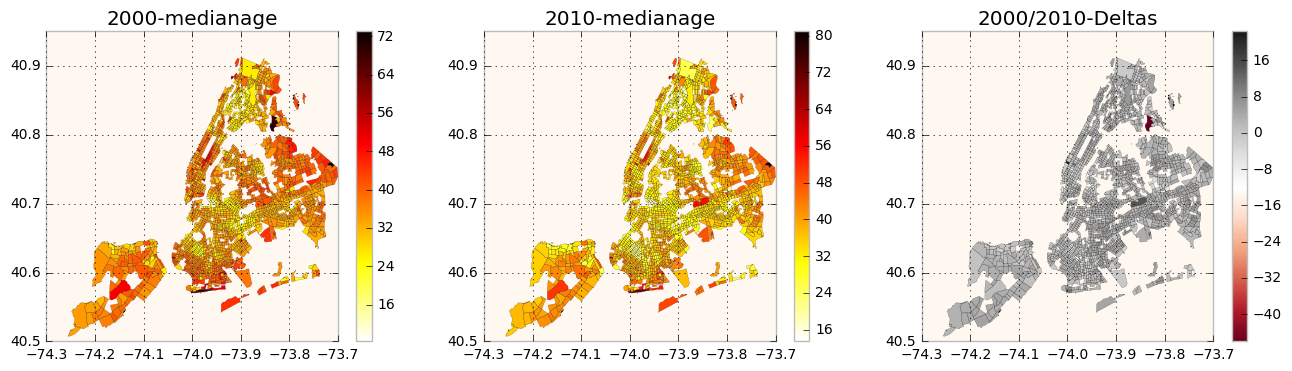

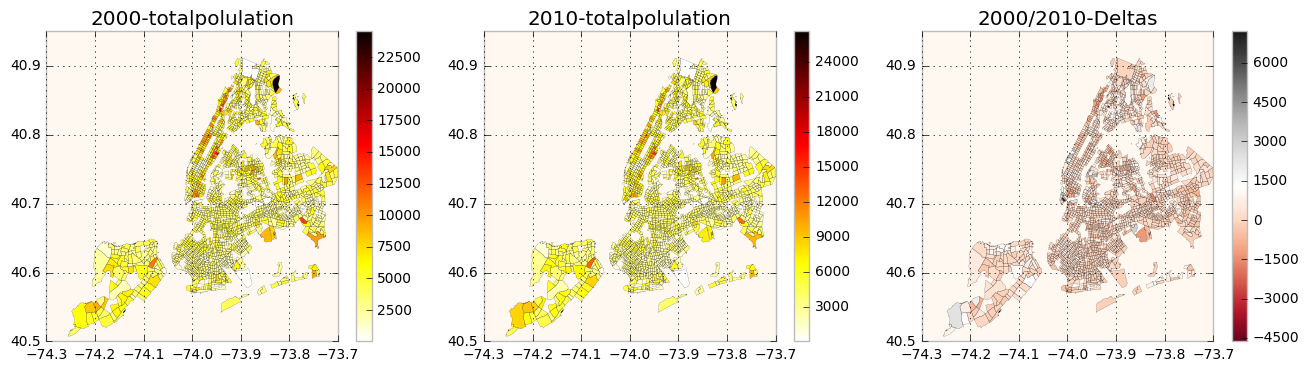

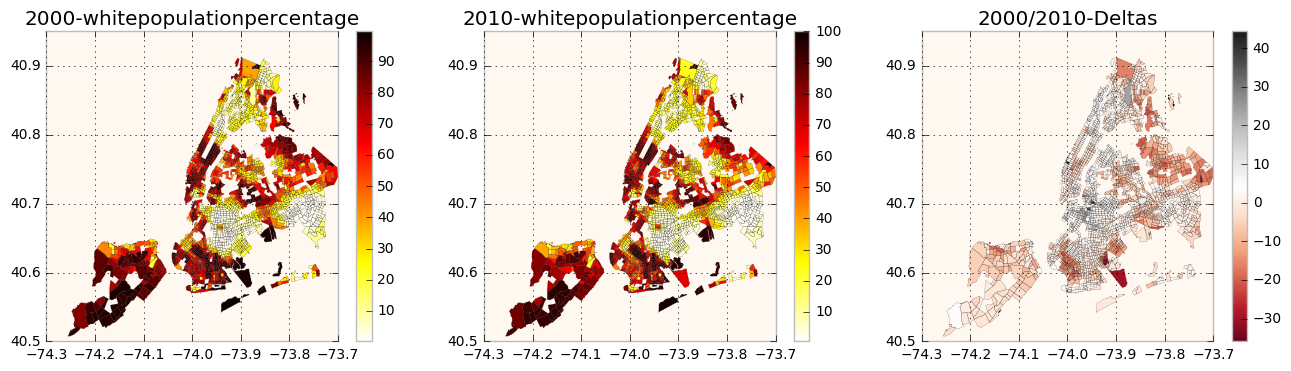

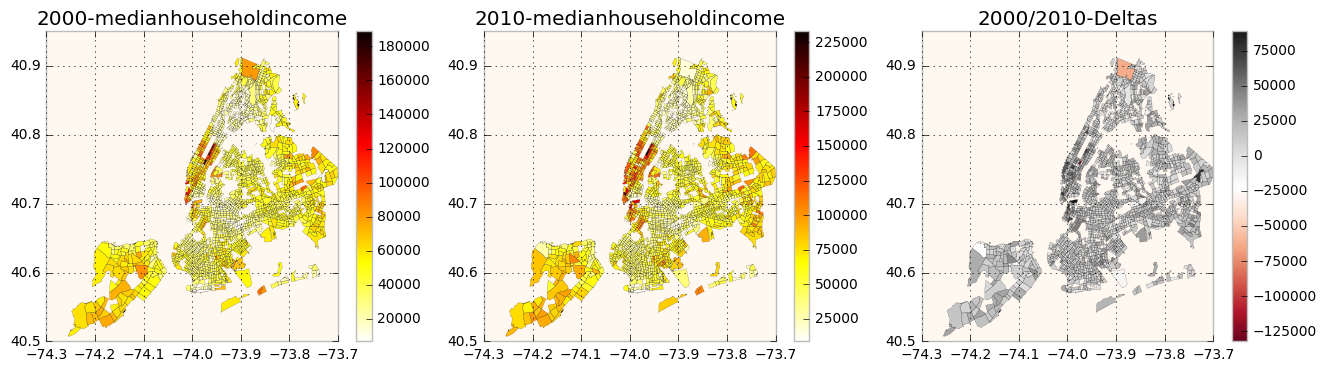

In [42]:
# Define collections of features and titles and generate Cloropeth Mosaic
features = ['medianage', 'totalpolulation','whitepopulationpercentage','medianhouseholdincome']
titles = ['2000', '2010']

generateCloropethMosaic(census2000DFClean, census2010DFClean, 'geo_id', features, titles, 'geometry_y_x')

Figure VI. This Cloropeth Mosaic presents the evolution of four different census statistics: median age, total population, white population percentage (to be used as a proxy for diversty), and median household income. Cloropeths on the same row present the same statistic, the one on the left presents the statistic values for the year 2000, the one in the middle for the year 2010 and the one on the right presnets the variations (2010 - 2000). The deltas colropeth provides insights on the specific socioechonomic changes over the last decade that are represented by these statistics: Growth (both economic and in terms of population) and composition of the population (diversity, using the percentage of white people as a proxy, and age using the hosehold income). The mosaic presents a general increase across median household income, total population and median age, and a slightly less homogeneous evolution for the diversity proxy, where there is both increase and decrease of the percentage of white population on several neighbours. 

### 8) Cluster the census tracts on these four features (using a Eucledian distance)

In [43]:
# Will use the K-Means Clustering algorithm to cluster the census tracts
# K-Means uses Eucledian Distance, and we will be using all four features 
# (we will not do PCA to reduce them to a two dimensional space)

# Preparing the data for K-Means: Whitening
# Whitening rescales each feature dimension of the observation by
# dividing it by its standard deviation across all observations to give it unit variance.

# We only want to Whiten the features columns!
whiten_columns = ['medianage', 'totalpolulation','whitepopulationpercentage','medianhouseholdincome']

census2000DFWhiten = census2000DFClean.copy()
census2010DFWhiten = census2010DFClean.copy()

# Whiten data.
census2000DFWhiten.loc[:, whiten_columns] = \
census2000DFWhiten[whiten_columns].apply(lambda col: col / col.std())

census2010DFWhiten.loc[:, whiten_columns] = \
census2010DFWhiten[whiten_columns].apply(lambda col: col / col.std())

In [44]:
# Reformat the whitened dataframes to apply K-Means

census2000DFWhiten.index = census2000DFWhiten['geo_id']
census2000DFWhiten = census2000DFWhiten[['medianage', 'totalpolulation',\
                                         'whitepopulationpercentage','medianhouseholdincome']]

census2010DFWhiten.index = census2010DFWhiten['geo_id']
census2010DFWhiten = census2010DFWhiten[['medianage', 'totalpolulation',\
                                         'whitepopulationpercentage','medianhouseholdincome']]

census2000DFWhiten.head()

medianage  totalpolulation  whitepopulationpercentage  \
geo_id                                                                        
1400000US36005000200   5.657824         1.632026                   1.037174   
1400000US36047001800   5.813544         0.663859                   1.315914   
1400000US36047070201   7.578370         2.993352                   3.114763   
1400000US36047096000   8.564596         0.001381                   3.241169   
1400000US36061009600   6.124984         0.096679                   1.682167   

                      medianhouseholdincome  
geo_id                                       
1400000US36005000200               2.240697  
1400000US36047001800               4.477286  
1400000US36047070201               3.581091  
1400000US36047096000               3.489649  
1400000US36061009600               3.164809

In [45]:
census2010DFWhiten.head()

medianage  totalpolulation  whitepopulationpercentage  \
geo_id                                                                        
1400000US36005000200   5.635142         2.050110                   1.043539   
1400000US36005000400   5.668388         2.603082                   0.924568   
1400000US36005001600   5.817994         2.669306                   0.938165   
1400000US36005001900   5.086589         0.906798                   1.046938   
1400000US36005002000   5.153080         4.130021                   0.771607   

                      medianhouseholdincome  
geo_id                                       
1400000US36005000200               2.302034  
1400000US36005000400               2.769243  
1400000US36005001600               1.168024  
1400000US36005001900               0.965549  
1400000US36005002000               0.959623

In [46]:
# K-Means Clustering for 2000

kmeans = KMeans(n_clusters=5, random_state=170)
clusters = kmeans.fit(census2000DFWhiten)

census2000DFWhiten['cluster'] = pd.Series(clusters.labels_, index=census2000DFWhiten.index)
census2000DFWhiten.head()

medianage  totalpolulation  whitepopulationpercentage  \
geo_id                                                                        
1400000US36005000200   5.657824         1.632026                   1.037174   
1400000US36047001800   5.813544         0.663859                   1.315914   
1400000US36047070201   7.578370         2.993352                   3.114763   
1400000US36047096000   8.564596         0.001381                   3.241169   
1400000US36061009600   6.124984         0.096679                   1.682167   

                      medianhouseholdincome  cluster  
geo_id                                                
1400000US36005000200               2.240697        1  
1400000US36047001800               4.477286        0  
1400000US36047070201               3.581091        0  
1400000US36047096000               3.489649        0  
1400000US36061009600               3.164809        1

In [47]:
# When running the second clustering, will initialize it
# using  the center of the cluster obtained from clustering the 2000 data

# https://docs.google.com/document/d/1dl5mxBcsZEBxqrAeMa39OdlmA6kbLdmY9Ioj56_oUTA/edit

#numpy array of initial centroids

centroids_array=clusters.cluster_centers_

centroids_array
#get the array

array([[ 7.00667616,  1.66294991,  2.71375291,  4.0257845 ],
       [ 5.86850631,  1.16853029,  0.65005732,  2.32562741],
       [ 4.96947405,  1.91710372,  0.79761258,  1.23841233],
       [ 6.04883301,  3.90823683,  1.58109012,  2.24277295],
       [ 6.55944734,  1.38683895,  2.37353989,  2.22732764]])

In [48]:
# K-Means Clustering for 2010

kmeans = KMeans(n_clusters=5, random_state=170, init=centroids_array)
clusters = kmeans.fit(census2010DFWhiten)

census2010DFWhiten['cluster'] = pd.Series(clusters.labels_, index=census2010DFWhiten.index)
census2010DFWhiten.head()

/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/sklearn/cluster/k_means_.py:821: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
  n_jobs=self.n_jobs)


medianage  totalpolulation  whitepopulationpercentage  \
geo_id                                                                        
1400000US36005000200   5.635142         2.050110                   1.043539   
1400000US36005000400   5.668388         2.603082                   0.924568   
1400000US36005001600   5.817994         2.669306                   0.938165   
1400000US36005001900   5.086589         0.906798                   1.046938   
1400000US36005002000   5.153080         4.130021                   0.771607   

                      medianhouseholdincome  cluster  
geo_id                                                
1400000US36005000200               2.302034        1  
1400000US36005000400               2.769243        3  
1400000US36005001600               1.168024        2  
1400000US36005001900               0.965549        2  
1400000US36005002000               0.959623        3

### 9) Identify the census tracts that have changed cluster assignment (those that are now associated with a different group of census tracts) and show a choropleth of the clusters in 2010, 2000 and a choropleth of the cluster changes.

In [49]:
# Prepare the dataframes with the cluster labels

census2010DFWhiten['geo_id'] = census2010DFWhiten.index
census2000DFWhiten['geo_id'] = census2000DFWhiten.index

DF2000Clusters = census2000DFWhiten[['geo_id', 'cluster']]
DF2010Clusters = census2010DFWhiten[['geo_id', 'cluster']]

DF2000Clusters.rename(columns={'cluster': 'cluster2000'}, inplace=True)
DF2010Clusters.rename(columns={'cluster': 'cluster2010'}, inplace=True)


/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/pandas/core/frame.py:2754: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  **kwargs)


In [50]:
# Join the cluster dataframes with the census tract dataframe using geo_id

clusterEvolutionDF = pd.merge(pd.merge(DF2000Clusters,DF2010Clusters,on='geo_id'),\
                              censusTractDF,on='geo_id')


In [51]:
# Add a new column that represets cluster change
clusterEvolutionDF['custerChange'] = (clusterEvolutionDF.cluster2000 - clusterEvolutionDF.cluster2010)\
!=0

In [52]:
# Recast clusterEvolutionDF to geodataframe for plotting

clusterEvolutionDF = GeoDataFrame(clusterEvolutionDF, geometry=clusterEvolutionDF.geometry)
type (clusterEvolutionDF)

clusterEvolutionDF.head()

geo_id  cluster2000  cluster2010 boro_code boro_ct_2010  \
0  1400000US36005000200            1            1         2      2000200   
1  1400000US36047070201            0            0         3      3070201   
2  1400000US36061009600            1            4         1      1009600   
3  1400000US36061005700            0            0         1      1005700   
4  1400000US36061009000            0            0         1      1009000   

   boro_name  cartodb_id cdeligibil ct_2010 ctlabel  \
0      Bronx        2134          I  000200       2   
1   Brooklyn        1605          I  070201  702.01   
2  Manhattan        2040          E  009600      96   
3  Manhattan        1064          I  005700      57   
4  Manhattan        1036          I  009000      90   

                                            geometry ntacode  \
0  (POLYGON ((-73.856516 40.805241, -73.856523999...    BX09   
1  (POLYGON ((-73.909114 40.616866, -73.90943 40....    BK45   
2  (POLYGON ((-73.977655 40.757911, -73.978116 40...    MN17   
3  (POLYGON ((-73.99039 40.731289, -73.990506 40....    MN23   
4  (POLYGON ((-73.966616 40.753243, -73.966655 40...    MN19   

                                           ntaname  puma     shape_area  \
0  Soundview-Castle Hill-Clason Point-Harding Park  3709   5004821.2311   
1   Georgetown-Marine Park-Bergen Beach-Mill Basin  4009  11069685.5521   
2                            Midtown-Midtown South  3807  1887288.31306   
3                                     West Village  3810  1155301.61546   
4                          Turtle Bay-East Midtown  3808  1906164.21271   

      shape_leng             allcodes custerChange  
0  15591.2827425      (Bronx, 000200)        False  
1  19339.1659485   (Brooklyn, 070201)        False  
2  5737.35624489  (Manhattan, 009600)         True  
3  4745.95013339  (Manhattan, 005700)        False  
4  5527.20982656  (Manhattan, 009000)        False

In [53]:
totalChanges = str (clusterEvolutionDF.custerChange.sum())
totalCT = str(len(clusterEvolutionDF))

print ('A total of ' + totalChanges + ' Census Tracts'
      + ' changed cluster out of the ' + totalCT + ' analyzed census tracts')

A total of 334 Census Tracts changed cluster out of the 1877 analyzed census tracts


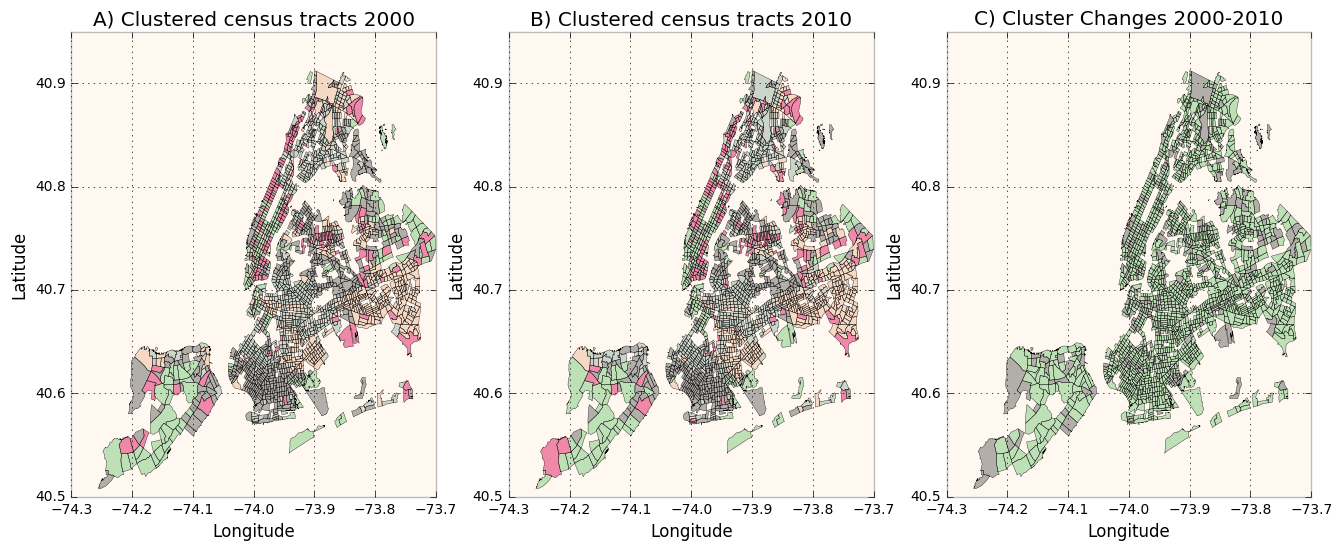

In [54]:
# Plot the cloroplaths for clusters and clusters changes

fig, (ax1, ax2, ax3) = pl.subplots(nrows=1, ncols=3, figsize=(16, 6))

# 2000 plot
clusterEvolutionDF.plot(column='cluster2000', cmap='Accent', linewidth=0.25, ax=ax1)

ax1.set_title('A) Clustered census tracts 2000')
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')

# 2010 plot
clusterEvolutionDF.plot(column='cluster2010', cmap='Accent', linewidth=0.25, ax=ax2)

ax2.set_title('B) Clustered census tracts 2010')
ax2.set_xlabel('Longitude')
ax2.set_ylabel('Latitude')

# Cluster Changes plot
clusterEvolutionDF.plot(column='custerChange', cmap='Accent', linewidth=0.25, ax=ax3)

ax3.set_title('C) Cluster Changes 2000-2010')
ax3.set_xlabel('Longitude')
ax3.set_ylabel('Latitude')

Figure VII. This Cloropeth series presents the changes on the census tract clusters that were previously derived from the k-menas clustering of the four features (median age, total population, white population percentage and median household income). 334 census tracts changed their cluster affiliation from 2000 to 2010, which is indicative of changes on their features that now makes them closer in terms of socioechonomic charactersitics to other census tracts. These tracts are identified with the gray color on the deltas cloropeth and are scattered across all five boroughts.

### 10) Aggregate the census four features at the zipcode level and merge the zipcode dataframe


In [55]:
# in order to aggregate the census tracts to zipcodes we will use
# The US census bureau Zip Code Tabulation Area relationship files
# These files created by examining the list of zip codes by census block
# and assigning to that block the most frequently ocurring ZIP code
# the blocks are later aggregated into larger areas.
# Details on how the USCB create these relationship files can be found here:
# http://www2.census.gov/geo/pdfs/education/brochures/ZCTAs.pdf

url = ('http://www2.census.gov/geo/docs/maps-data/data/rel/zcta_tract_rel_10.txt')

if not os.path.isfile(puidata + "/zcta_tract_rel_10.txt"):
    os.system("curl -o zcta_tract_rel_10.txt " + url)
    os.system("mv zcta_tract_rel_10.txt " + os.getenv("PUIDATA"))

# Be careful of using dtype=object otherwise it converts the TRACT to an int!
# and takes out the leading zeroes (which makes it unsuitable for the merge)
zcta_tractDF = pd.read_csv(puidata + "/zcta_tract_rel_10.txt", dtype=object)
zcta_tractDF.head()

ZCTA5 STATE COUNTY   TRACT        GEOID POPPT  HUPT    AREAPT  AREALANDPT  \
0  00601    72    001  956300  72001956300  4271  1706  44663250    44572589   
1  00601    72    001  956400  72001956400  2384  1037  32830481    32492074   
2  00601    72    001  956500  72001956500  3126  1240  44969548    44809680   
3  00601    72    001  956600  72001956600  2329   972   1981101     1981101   
4  00601    72    001  956700  72001956700  2053   948   1380041     1380041   

    ZPOP      ...         TRAREA TRAREALAND ZPOPPCT ZHUPCT ZAREAPCT  \
0  18570      ...       44924558   44833897      23  22.03    26.67   
1  18570      ...       37782601   37191697   12.84  13.39    19.61   
2  18570      ...       44969548   44809680   16.83  16.01    26.85   
3  18570      ...        1981101    1981101   12.54  12.55     1.18   
4  18570      ...        1380041    1380041   11.06  12.24      .82   

  ZAREALANDPCT TRPOPPCT TRHUPCT TRAREAPCT TRAREALANDPCT  
0        26.74     98.5   98.33     99.42         99.42  
1         19.5     79.6   80.14     86.89         87.36  
2        26.89      100     100       100           100  
3         1.19      100     100       100           100  
4          .83      100     100       100           100  

[5 rows x 25 columns]

In [56]:
# Extract only New York and necessary columns
# New York State ID is 36
# New York City Counties are

#005 - Bronx
#047 - Kings (Brooklyn)
#061 - New York (Manhattan)
#081 - Queens
#085 - Richmond (Staten Island)

zcta_tractDF = zcta_tractDF[['ZCTA5','COUNTY','TRACT']][(zcta_tractDF.STATE == '36')\
                                               & ((zcta_tractDF.COUNTY == '005')\
                                                 |(zcta_tractDF.COUNTY == '047')\
                                                  |(zcta_tractDF.COUNTY == '061')\
                                                  |(zcta_tractDF.COUNTY == '081')\
                                                  |(zcta_tractDF.COUNTY == '085')\
                                                 )]

In [57]:
# Tweak the censusTractDF for the merge rename the ct to TRACT
# Create a COUNTY column sing the FBB HIN on geo_id format

censusTractDF.rename(columns={'ct_2010': 'TRACT'}, inplace=True)
censusTractDF['COUNTY'] = censusTractDF.geo_id.str[11:-6]

In [58]:
# Merge!
censusTracZiptDF = pd.merge(zcta_tractDF, censusTractDF,on=['TRACT','COUNTY'])  

In [59]:
# Basic Checks, format, number of CTs after the merge
censusTracZiptDF.count()
censusTracZiptDF.head()

ZCTA5 COUNTY   TRACT boro_code boro_ct_2010  boro_name  cartodb_id  \
0  10001    061  005800         1      1005800  Manhattan        1833   
1  10010    061  005800         1      1005800  Manhattan        1833   
2  10001    061  007600         1      1007600  Manhattan        1363   
3  10001    061  009100         1      1009100  Manhattan        1841   
4  10011    061  009100         1      1009100  Manhattan        1841   

  cdeligibil ctlabel                                           geometry  \
0          I      58  (POLYGON ((-73.987298 40.744681, -73.987747 40...   
1          I      58  (POLYGON ((-73.987298 40.744681, -73.987747 40...   
2          I      76  (POLYGON ((-73.984076 40.749102, -73.984561 40...   
3          I      91  (POLYGON ((-73.99141899999999 40.744803, -73.9...   
4          I      91  (POLYGON ((-73.99141899999999 40.744803, -73.9...   

  ntacode                                     ntaname  puma     shape_area  \
0    MN13  Hudson Yards-Chelsea-Flatiron-Union Square  3807   1879690.3674   
1    MN13  Hudson Yards-Chelsea-Flatiron-Union Square  3807   1879690.3674   
2    MN17                       Midtown-Midtown South  3807  1873515.02893   
3    MN13  Hudson Yards-Chelsea-Flatiron-Union Square  3807  1927040.21793   
4    MN13  Hudson Yards-Chelsea-Flatiron-Union Square  3807  1927040.21793   

      shape_leng             allcodes                geo_id  
0  5720.57681966  (Manhattan, 005800)  1400000US36061005800  
1  5720.57681966  (Manhattan, 005800)  1400000US36061005800  
2  5717.63353045  (Manhattan, 007600)  1400000US36061007600  
3  5743.39356986  (Manhattan, 009100)  1400000US36061009100  
4  5743.39356986  (Manhattan, 009100)  1400000US36061009100

In [60]:
# Rename column for future merge
censusTracZiptDF.rename(columns={'ZCTA5': 'zip'}, inplace=True)

In [61]:
# Merge ZIPs with the 2010DF
census2010DFCleanZip = pd.merge(census2010DFClean, censusTracZiptDF,on='geo_id')

In [62]:
# Basic checks after merge
#census2010DFCleanZip.head()
#census2010DFCleanZip.count()
#census2010DFClean.count()

In [63]:
# Merge ZIPs with the 2000DF
census2000DFCleanZip = pd.merge(census2000DFClean, censusTracZiptDF,on='geo_id')  

In [64]:
# More basic checks
#census2000DFCleanZip.columns
#census2000DFCleanZip.count()
#census2000DFClean.count()

In [65]:
# Will furtrher refine the dataframe and aggregate by taking the mean on all census values
census2000DFCleanZip = census2000DFCleanZip[['zip','medianage','totalpolulation','whitepopulationpercentage',\
                                            'medianhouseholdincome']]

census2000DFCleanZip = census2000DFCleanZip.groupby(['zip'], as_index=False).mean()

In [66]:
# Will furtrher refine the dataframe and aggregate by taking the mean on all census values

census2010DFCleanZip = census2010DFCleanZip[['zip','medianage','totalpolulation','whitepopulationpercentage',\
                                            'medianhouseholdincome']]

census2010DFCleanZip = census2010DFCleanZip.groupby(['zip'], as_index=False).mean()

In [67]:
#census2000DFCleanZip.count()

### 11) Repeat steps 7,8,9 at the zipcode level with the added feature (number of businesses)

In [68]:
# Merge the dataframes for census with zips and the business with zips 
# Display each of the features as a choropleth for both 2010 and 2000, 
# and show the difference in the features as a third choroplath.


# Merge ZIPs with the 2010DF
geoDFcomplete2000 = pd.merge(census2000DFCleanZip, geoDfBusiness2000,on='zip')
geoDFcomplete2010 = pd.merge(census2010DFCleanZip, geoDfBusiness2010,on='zip')

In [69]:
# Rename column for future merge
geoDFcomplete2000.rename(columns={'EST': 'totalbusiness'}, inplace=True)
geoDFcomplete2010.rename(columns={'est': 'totalbusiness'}, inplace=True)

geoDFcomplete2000 = GeoDataFrame(geoDFcomplete2000, geometry=geoDFcomplete2000.geometry)
geoDFcomplete2010 = GeoDataFrame(geoDFcomplete2010, geometry=geoDFcomplete2010.geometry)

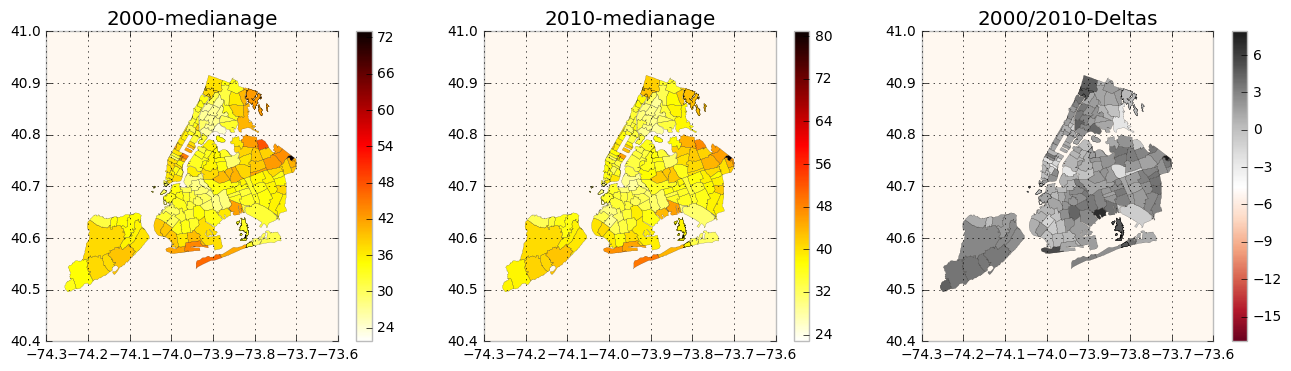

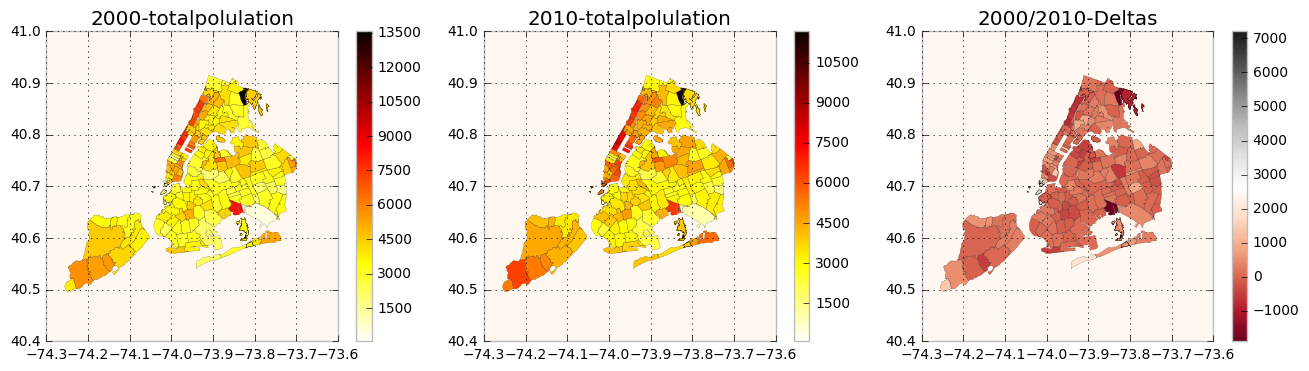

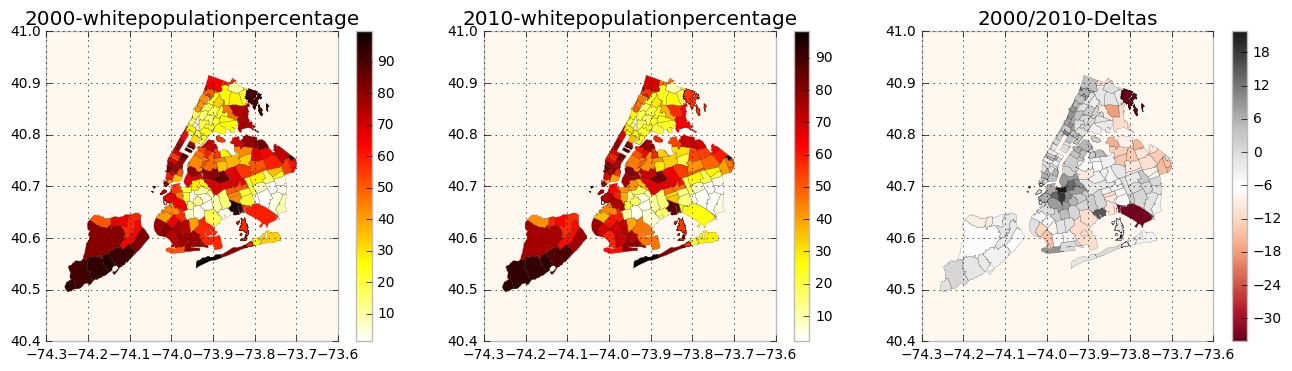

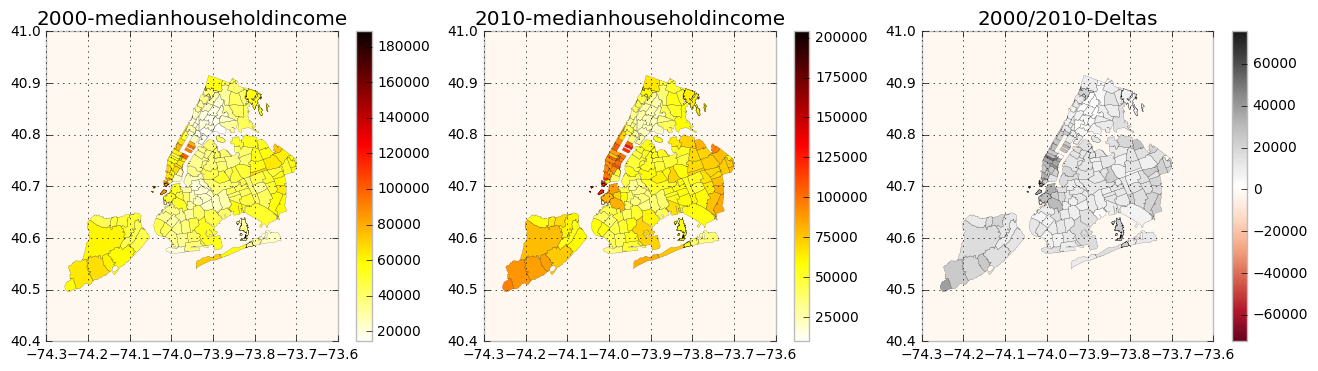

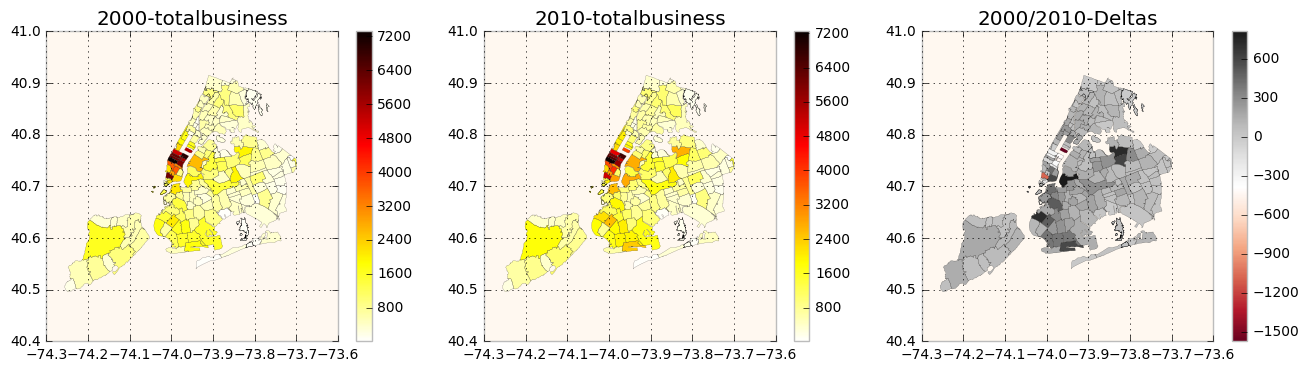

In [70]:
# Define collections of features and titles and generate Cloropeth Mosaic
features = ['medianage', 'totalpolulation','whitepopulationpercentage','medianhouseholdincome'\
            ,'totalbusiness']

titles = ['2000', '2010']

generateCloropethMosaic(geoDFcomplete2000, geoDFcomplete2010, 'zip', features, titles, 'geometry_y')

Figure VIII. This Cloropeth Mosaic is similar to the one presented in figure VI, the two differences is the aggregation of the data (this time at the zip level, rather than the census tract) and the adition of a fifth feature (the total number of business) which was not available at the census tract level. The observations are consistent wth the previous figure, For the new feature -total number of business per zip- we observe a predominant positive growth for most of the zipcodes across all five boroguhs, with some isolated exceptions on zips in downtown manhattan, where the reduction is significant and midtown east.

In [71]:
# Will use the K-Means Clustering algorithm to cluster the zips
# K-Means uses Eucledian Distance, and we will be using all four features 
# (we will not do PCA to reduce them to a two dimensional space)

# Preparing the data for K-Means: Whitening
# Whitening rescales each feature dimension of the observation by
# dividing it by its standard deviation across all observations to give it unit variance.

# We only want to Whiten the features columns!
whiten_columns = ['medianage', 'totalpolulation','whitepopulationpercentage',\
                  'medianhouseholdincome', 'totalbusiness']

geoDFcomplete2000Whiten = geoDFcomplete2000.copy()
geoDFcomplete2010Whiten = geoDFcomplete2010.copy()

# Whiten data.
geoDFcomplete2000Whiten.loc[:, whiten_columns] = \
geoDFcomplete2000Whiten[whiten_columns].apply(lambda col: col / col.std())

geoDFcomplete2010Whiten.loc[:, whiten_columns] = \
geoDFcomplete2010Whiten[whiten_columns].apply(lambda col: col / col.std())

In [72]:
# Reformat the whitened dataframes to apply K-Means

geoDFcomplete2000Whiten.index = geoDFcomplete2000Whiten['zip']
geoDFcomplete2000Whiten = geoDFcomplete2000Whiten[['medianage', 'totalpolulation',\
                                         'whitepopulationpercentage','medianhouseholdincome',\
                                                  'totalbusiness']]

geoDFcomplete2010Whiten.index = geoDFcomplete2010Whiten['zip']
geoDFcomplete2010Whiten = geoDFcomplete2010Whiten[['medianage', 'totalpolulation',\
                                         'whitepopulationpercentage','medianhouseholdincome',\
                                                  'totalbusiness']]
geoDFcomplete2000Whiten.head()

medianage  totalpolulation  whitepopulationpercentage  \
zip                                                            
10001   6.439804         1.532882                   2.492307   
10002   6.492165         3.364717                   1.312392   
10003   5.880979         2.982129                   2.919740   
10004   5.267207         0.875880                   2.640880   
10004   5.267207         0.875880                   2.640880   

       medianhouseholdincome  totalbusiness  
zip                                          
10001               2.591710       5.711608  
10002               1.142003       1.777413  
10003               3.130533       2.874929  
10004               3.929680       1.010089  
10004               3.929680       1.010089

In [73]:
# Zips K-Means Clustering for 2000

kmeans = KMeans(n_clusters=5, random_state=170)
clusters = kmeans.fit(geoDFcomplete2000Whiten)

geoDFcomplete2000Whiten['cluster'] = pd.Series(clusters.labels_, index=geoDFcomplete2000Whiten.index)
geoDFcomplete2000Whiten.head()

medianage  totalpolulation  whitepopulationpercentage  \
zip                                                            
10001   6.439804         1.532882                   2.492307   
10002   6.492165         3.364717                   1.312392   
10003   5.880979         2.982129                   2.919740   
10004   5.267207         0.875880                   2.640880   
10004   5.267207         0.875880                   2.640880   

       medianhouseholdincome  totalbusiness  cluster  
zip                                                   
10001               2.591710       5.711608        2  
10002               1.142003       1.777413        0  
10003               3.130533       2.874929        2  
10004               3.929680       1.010089        1  
10004               3.929680       1.010089        1

In [74]:
# When running the second clustering, will initialize it
# using  the center of the cluster obtained from clustering the 2000 data

# https://docs.google.com/document/d/1dl5mxBcsZEBxqrAeMa39OdlmA6kbLdmY9Ioj56_oUTA/edit

#numpy array of initial centroids

centroids_array=clusters.cluster_centers_

In [75]:
# K-Means Clustering for 2010

kmeans = KMeans(n_clusters=5, random_state=170, init=centroids_array)
clusters = kmeans.fit(geoDFcomplete2010Whiten)

geoDFcomplete2010Whiten['cluster'] = pd.Series(clusters.labels_, index=geoDFcomplete2010Whiten.index)
geoDFcomplete2010Whiten.head()

medianage  totalpolulation  whitepopulationpercentage  \
zip                                                            
10001   6.098813         2.027707                   2.593578   
10002   6.900305         3.351369                   1.587276   
10003   5.670843         3.247456                   3.097994   
10004   5.317634         3.111656                   2.840136   
10004   5.317634         3.111656                   2.840136   

       medianhouseholdincome  totalbusiness  cluster  
zip                                                   
10001               3.136554       5.897568        2  
10002               1.334001       2.339154        0  
10003               3.175068       3.349910        2  
10004               4.150150       1.138627        4  
10004               4.150150       1.138627        4

In [76]:
# Prepare the dataframes with the cluster labels

geoDFcomplete2000Whiten['zip'] = geoDFcomplete2000Whiten.index
geoDFcomplete2010Whiten['zip'] = geoDFcomplete2010Whiten.index

DF2000ClustersZip = geoDFcomplete2000Whiten[['zip', 'cluster']]
DF2010ClustersZip = geoDFcomplete2010Whiten[['zip', 'cluster']]

DF2000ClustersZip.rename(columns={'cluster': 'cluster2000'}, inplace=True)
DF2010ClustersZip.rename(columns={'cluster': 'cluster2010'}, inplace=True)


In [77]:
# Join the cluster dataframes with the census tract dataframe using geo_id

clusterEvolutionDFZip = pd.merge(pd.merge(DF2000ClustersZip,DF2010ClustersZip,on='zip'),\
                              geoZips,on='zip')

# Add a new column that represets cluster change
clusterEvolutionDFZip['custerChange'] = (clusterEvolutionDFZip.cluster2000 - clusterEvolutionDFZip.cluster2010)\
!=0

In [78]:
temp = pd.merge(DF2000ClustersZip,DF2010ClustersZip,on='zip')
#temp.count()

zip            251
cluster2000    251
cluster2010    251
dtype: int64

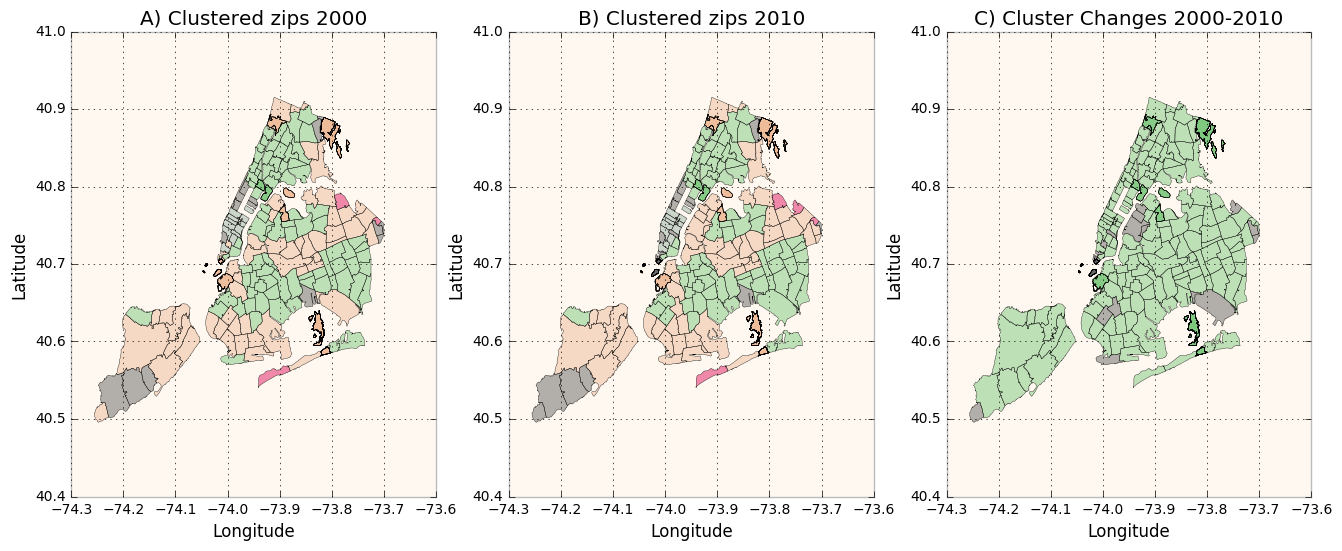

In [81]:
# Plot the cloroplaths for clusters and clusters changes
fig, (ax1, ax2, ax3) = pl.subplots(nrows=1, ncols=3, figsize=(16, 6))

# 2000 plot
clusterEvolutionDFZip = GeoDataFrame(clusterEvolutionDFZip)

clusterEvolutionDFZip.plot(column='cluster2000', cmap='Accent', linewidth=0.25, ax=ax1)

ax1.set_title('A) Clustered zips 2000')
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')

# 2010 plot
clusterEvolutionDFZip.plot(column='cluster2010', cmap='Accent', linewidth=0.25, ax=ax2)

ax2.set_title('B) Clustered zips 2010')
ax2.set_xlabel('Longitude')
ax2.set_ylabel('Latitude')

# Cluster Changes plot
clusterEvolutionDFZip.plot(column='custerChange', cmap='Accent', linewidth=0.25, ax=ax3)

ax3.set_title('C) Cluster Changes 2000-2010')
ax3.set_xlabel('Longitude')
ax3.set_ylabel('Latitude')

Figure IX. This Cloropeth series presents the changes on the zip clusters that were previously derived from the k-menas clustering of the five zip features (median age, total population, white population percentage, median household income and total number of business). On Maps A and B, equal color represent same cluster affiliation. A relatively small number of zips changed their cluster affiliation from 2000 to 2010, which is indicative of changes on their features that now makes them closer in terms of socioechonomic charactersitics to other zips. These tracts are identified with the gray color on the deltas cloropeth and are only present in three of the boroughs: Staten Island, Brooklyn and Queens (In contrst with the cluster afiliation changes for census tracts, which were present on all five boroghs)


### 12) Define a function that given a dataframe containing the relevant information and two cluster labels finds if the census tract changed cluster assignments from the first to the second label, and if so finds the individual features that are significantly different as measured by Pearson's correlation, plot those census tracts, and plot a histogram of the features that have significantly changed. Run your function for all label pairs (2 points, one for the identification of locations that changed cluster and one for the identifiation of the features that changed significantly).

In [82]:
# The format for the parameter dataframe of the function is displayed bellow the next cell:
# It is a (Merge CT features for 2000 and 2010 with the clusterEvolutionDF generate in K-Means
clusterEvolutionDFFull = pd.merge((pd.merge(census2000DFClean, census2010DFClean,on='geo_id')\
                                  ), clusterEvolutionDF,on='geo_id')

In [88]:
df = clusterEvolutionDFFull.copy()
df.head()

geo_id  medianage_x  totalpolulation_x  \
0  1400000US36005000200         32.7               3545   
1  1400000US36047070201         43.8               6502   
2  1400000US36061009600         35.4                210   
3  1400000US36061005700         39.0               2535   
4  1400000US36061009000         37.0               7599   

   whitepopulationpercentage_x boro_name_x  medianhouseholdincome_x  \
0                         32.0       Bronx                    42539   
1                         96.1    Brooklyn                    67986   
2                         51.9   Manhattan                    60083   
3                         88.9   Manhattan                    97765   
4                         75.8   Manhattan                    80953   

                                        geometry_y_x  medianage_y  \
0  (POLYGON ((-73.856516 40.805241, -73.856523999...         33.9   
1  (POLYGON ((-73.909114 40.616866, -73.90943 40....         42.8   
2  (POLYGON ((-73.977655 40.757911, -73.978116 40...         36.5   
3  (POLYGON ((-73.99039 40.731289, -73.990506 40....         38.7   
4  (POLYGON ((-73.966616 40.753243, -73.966655 40...         36.0   

   totalpolulation_y  whitepopulationpercentage_y     ...      ct_2010  \
0               4334                         30.7     ...       000200   
1               6573                         95.2     ...       070201   
2                155                         67.1     ...       009600   
3               2781                         86.8     ...       005700   
4               7883                         74.0     ...       009000   

   ctlabel                                           geometry  ntacode  \
0        2  (POLYGON ((-73.856516 40.805241, -73.856523999...     BX09   
1   702.01  (POLYGON ((-73.909114 40.616866, -73.90943 40....     BK45   
2       96  (POLYGON ((-73.977655 40.757911, -73.978116 40...     MN17   
3       57  (POLYGON ((-73.99039 40.731289, -73.990506 40....     MN23   
4       90  (POLYGON ((-73.966616 40.753243, -73.966655 40...     MN19   

                                           ntaname  puma     shape_area  \
0  Soundview-Castle Hill-Clason Point-Harding Park  3709   5004821.2311   
1   Georgetown-Marine Park-Bergen Beach-Mill Basin  4009  11069685.5521   
2                            Midtown-Midtown South  3807  1887288.31306   
3                                     West Village  3810  1155301.61546   
4                          Turtle Bay-East Midtown  3808  1906164.21271   

      shape_leng             allcodes custerChange  
0  15591.2827425      (Bronx, 000200)        False  
1  19339.1659485   (Brooklyn, 070201)        False  
2  5737.35624489  (Manhattan, 009600)         True  
3  4745.95013339  (Manhattan, 005700)        False  
4  5527.20982656  (Manhattan, 009000)        False  

[5 rows x 30 columns]

In [89]:
def analyzeCensusTractEvolution(df, clusterLabel1, clusterLabel2):
    """ this function analises the evolution of a census tract
    for those tracts that changed cluster affiliation from label 1 to label 2.
    The analisis consists on finding the individual features that are significantly 
    different as measured by Pearson's correlation, plot those census tracts,
    and plot a histogram of the features that have significantly changed.
    Arguments:
    df, a geodataframe containing all the features for the 2000 and 2010 census
    for all census tracts, along with their clustering afiliations
    clusterLabel1, clusterLabel2: The labels of the clusters to be used to isolate
    the specific census tracts for 2000 and 2010 respectively
    """
    
    # Use broadcast to filter the dataset to only those tracts that changed cluster
    # from the cluster with label1 to the cluster with label2
    dfTemp = df[(df.cluster2000 == clusterLabel1)& (df.cluster2010 == clusterLabel2)]
   
    # Get the pearsons correlations for each of the four features
    corrMedianAge = (np.corrcoef(dfTemp.medianage_x,\
                   dfTemp.medianage_y)[0, 1])
    corrTotalPop = (np.corrcoef(dfTemp.totalpolulation_x,\
                        dfTemp.totalpolulation_y)[0, 1])
    corrWhitePerc = (np.corrcoef(dfTemp.whitepopulationpercentage_x,\
                        dfTemp.whitepopulationpercentage_y)[0, 1])
    corrMedianHouse = (np.corrcoef(dfTemp.medianhouseholdincome_x,\
                        dfTemp.medianhouseholdincome_y)[0, 1])
    
    #Recast the dataframes to geodataframes
    df = GeoDataFrame(df, geometry=df.geometry)
    dfTemp = GeoDataFrame(dfTemp, geometry=dfTemp.geometry)
    
    pearsons = {'medianAge': corrMedianAge, 'totalPopulation': corrTotalPop,\
                 'whitepopulationpercentage': corrWhitePerc, 'medianhouseholdincome': corrMedianHouse }
    
    sorted_pearsons = sorted(pearsons.items(), key=operator.itemgetter(1))
    
    # Create a title for the plot
    fig, (ax1) = pl.subplots(nrows=1, ncols=1, figsize=(16, 0.1))
    ax1.get_yaxis().set_visible(False)
    ax1.get_xaxis().set_visible(False)
    ax1.set_axis_bgcolor('black')
    ax1.set_title('Analisis of the Census tract cluster affiliation changes, clusters ' + str(clusterLabel1)\
                      + ' to ' + str (clusterLabel2), fontsize=15)
    
    # Print the sorted dictionary to have an idea of the relation between
    # the features (will output the object as one of outputs)
    # print ("Features Pearsons Correlations (From weaker to stronger) " + str(sorted_pearsons))
    
    # Plot The Census Tracts
    fig, (ax1, ax2) = pl.subplots(nrows=1, ncols=2, figsize=(14, 6))

    # Create custom color map (a single color!)
    mycolor = ListedColormap('white')
    df.plot(colormap=mycolor, alpha=0.5, ax=ax1, linewidth=0.15)
    
    # Plot only the CTs that changed direction
    dfTemp.plot(column='cluster2000', cmap='Accent', linewidth=0.35, ax=ax1)

    ax1.set_title('Census Tracts that changed from cluster ' + str(clusterLabel1)\
                  + ' to ' + str (clusterLabel2) + "\n", fontsize=12)
    ax1.set_xlabel('Longitude')
    ax1.set_ylabel('Latitude')
        
    # Create a historgram with the features
    X = np.arange(len(pearsons))
    ax2.bar(X, pearsons.values(), align='center', width=0.5)
    ind = np.arange(len(pearsons))
    width = 0.50
    xTickMarks = pearsons.keys()
    ax2.set_xticks(ind)
    xtickNames = ax2.set_xticklabels(xTickMarks)
    plt.setp(xtickNames, rotation=25, fontsize=10)
    ax2.set_ylabel('Pearsons Coefficient')
    ymax = max(pearsons.values())
    ax2.set_title('Pearsons Correlations between same Clusters features \n' , fontsize=12)
    #ax2.ylim(0, ymax)
    
    # Create a title for the plot
    fig, (ax1) = pl.subplots(nrows=1, ncols=1, figsize=(16, 0.01))
    ax1.get_yaxis().set_visible(False)
    ax1.get_xaxis().set_visible(False)
    ax1.set_axis_bgcolor('white')
    ax1.set_title('There are a total of ' + str(len(dfTemp)) + ' tracts that changed cluster affiliation.'\
                      + ' the strongest Pearson Coefficient is for ' + str (sorted_pearsons[3][0])\
                  + ' with a value of ' + str (sorted_pearsons[3][1]) + ', and the weakest '\
                  + str (sorted_pearsons[0][0]) + ' with a value of ' + str (sorted_pearsons[0][1])\
                  , fontsize=20)
           
    return sorted_pearsons

In [90]:
# Get the collection of unique cluster affiliation changes
df = df[(df.custerChange == True)]
df = df[['cluster2000', 'cluster2010']]
dfUnique = df.drop_duplicates()
print ('There is a total of ' + str(len(dfUnique)) + ' unique type of census trackt cluster affiliation changes'\
       + ' between 2000 and 2010')

There is a total of 18 unique type of census trackt cluster affiliation changes between 2000 and 2010


/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/geopandas/plotting.py:225: FutureWarning: 'colormap' is deprecated, please use 'cmap' instead (for consistency with matplotlib)
  "(for consistency with matplotlib)", FutureWarning)


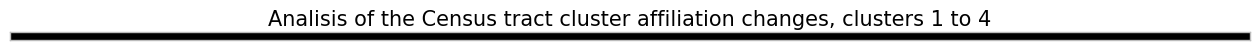

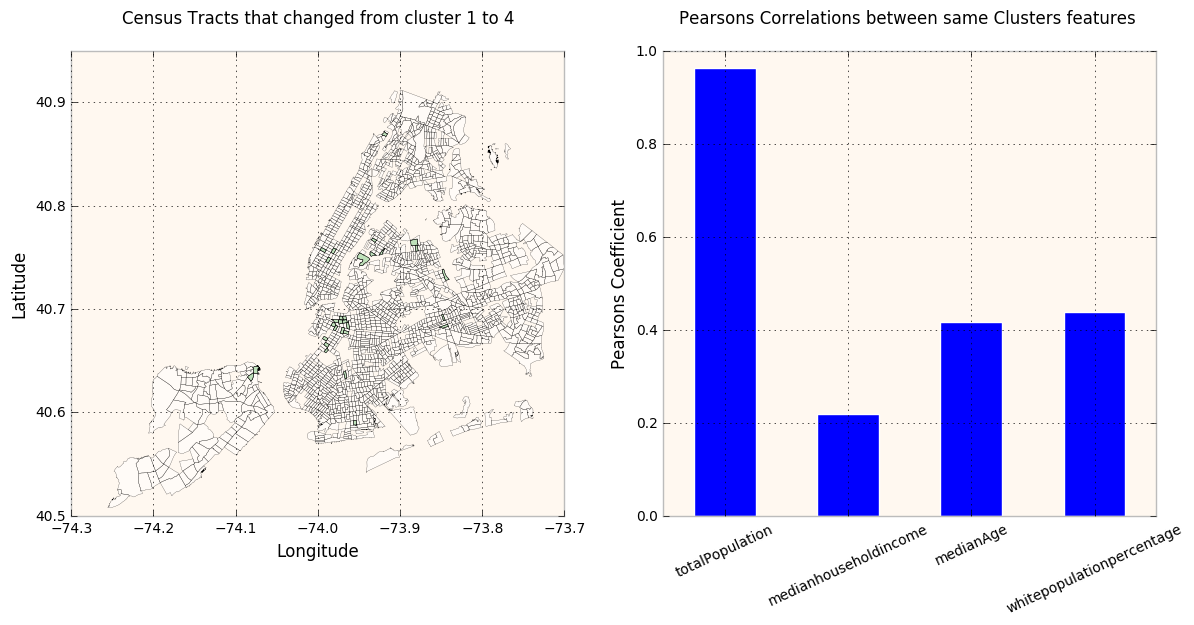

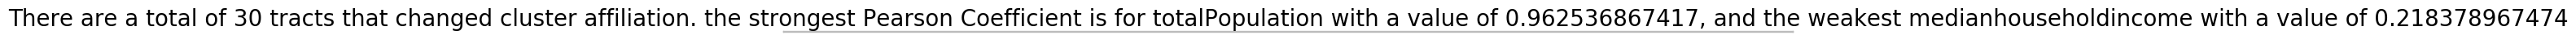

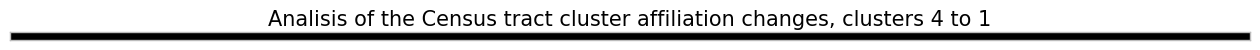

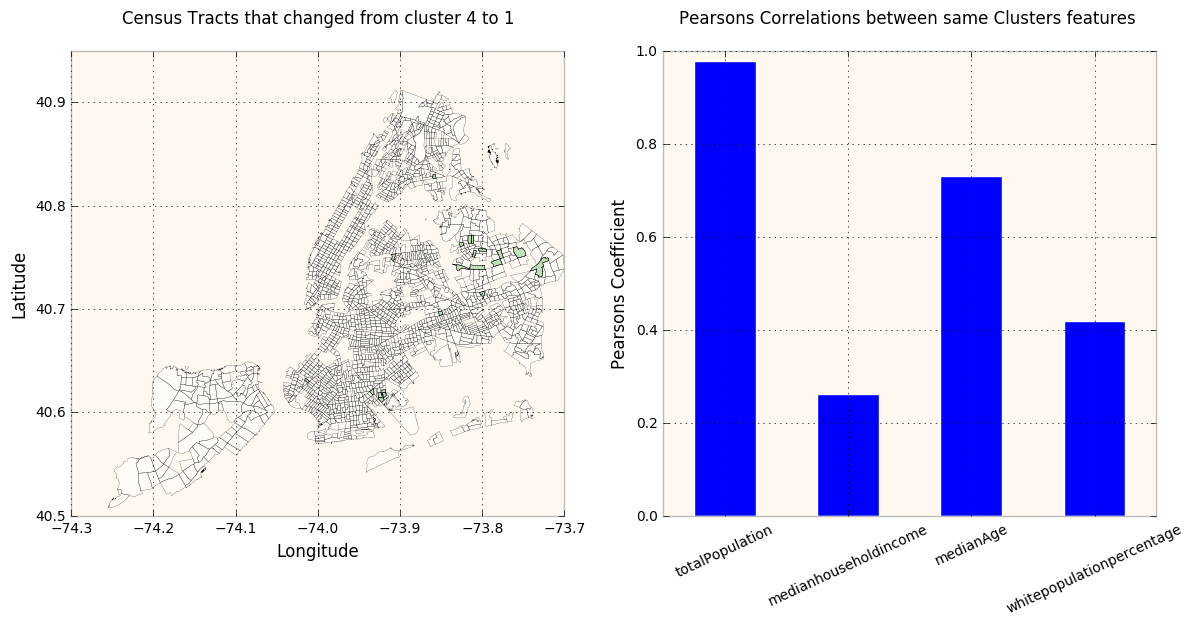

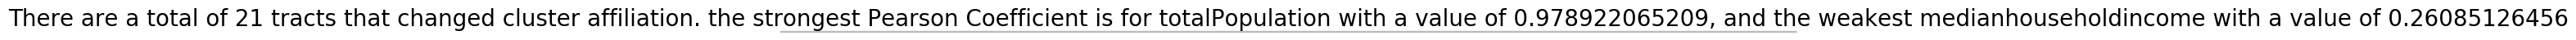

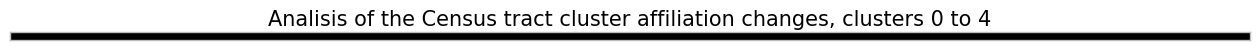

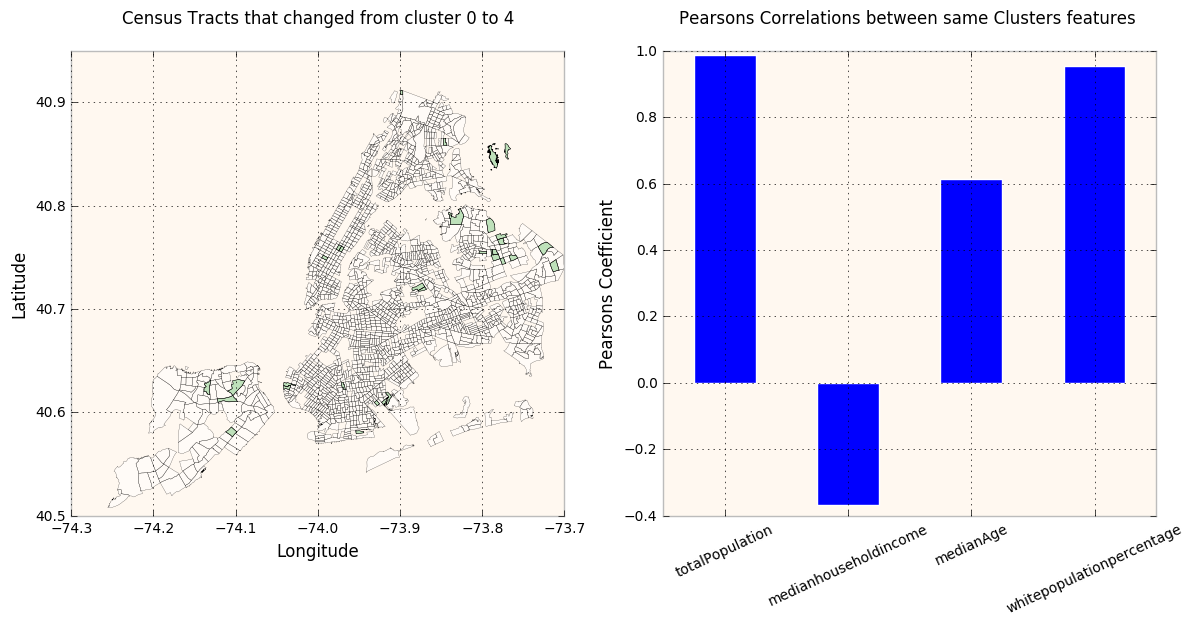

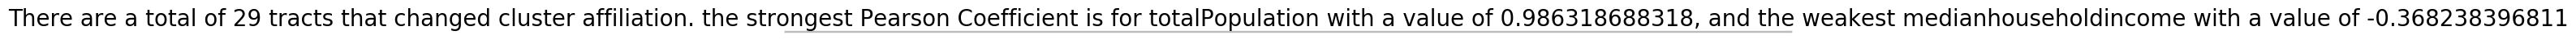

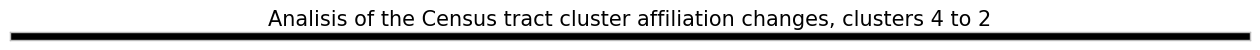

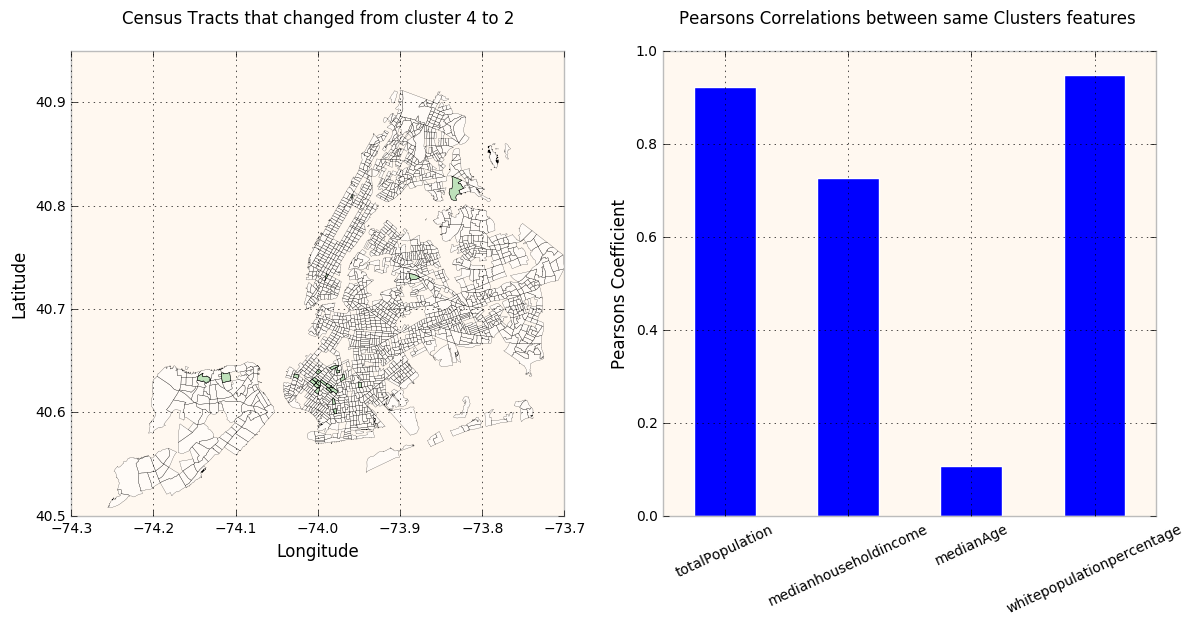

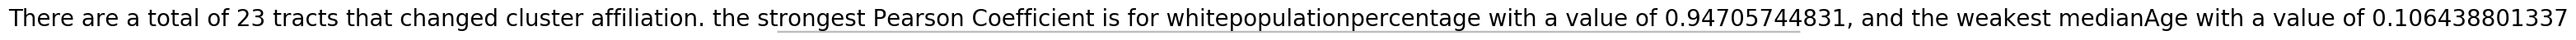

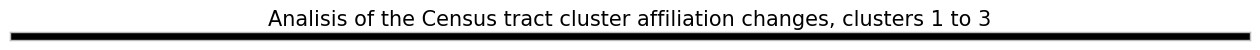

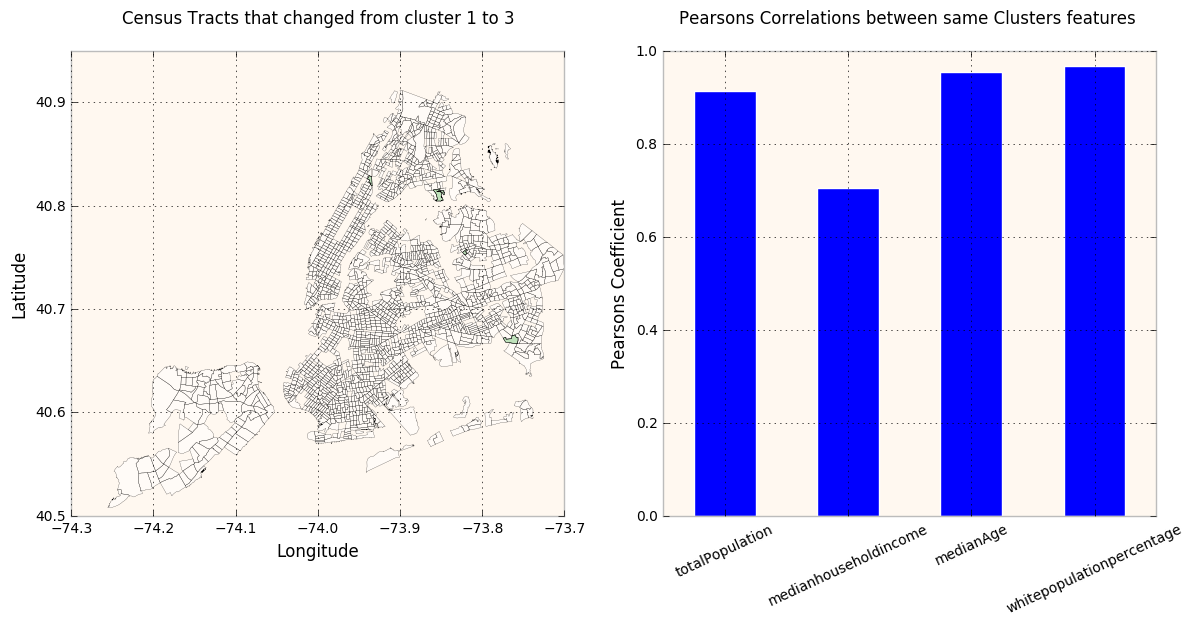

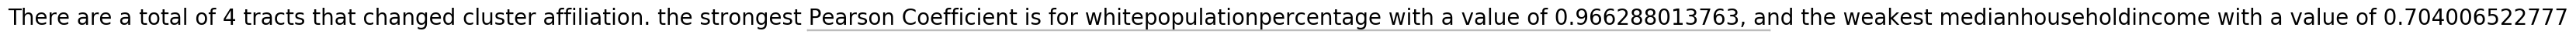

In [86]:
# Iterate trough the collection of unique cluster affiliation changes
# and analyze the census tract evolution for each of them
# will only look through the first four as an example and leave a commented
# line to do the rest if desired

# Complete collection of cluster affiliation changes
#for index, row in dfUnique.iterrows():
#    analyzeCensusTractEvolution(clusterEvolutionDFFull,row['cluster2000'], row['cluster2010'])

# Using head to get only the first 5 entries
for index, row in dfUnique.head().iterrows():
    analyzeCensusTractEvolution(clusterEvolutionDFFull,row['cluster2000'], row['cluster2010'])

Figure X. This combined Cloropeth / Histogram series presents the census tract cluster affiliation changes that happened between 2000 and 2010. These clusters were derived from the k-means clustering of the four Census Tract features (median age, total population, white population percentage and median household income). For each of the cluster affiliation changes the map presents in light green color the changing census tracts along with a meassure of the differences between the individual features for 2000 and 2010, taken by calculating their Pearsons Coefficient.

### 13) Comment on the strength and weaknesses of this analysis, and on your findings (this is not the last step, but comments should be given throughout the notebook, and summarized here).

#### Conclusions, Strengths and weaknesses

1) The work on this notebook focused on the manipulation and representation of socioeconomic indicators that enable drawing conclusions on the evolution of the city population and the economy. Most of the indicators were available at the census tract level, which enabled a very granular analysis in terms of geographic location.

2) In terms of economic growth, most of the city has experimented noticeable economic growth between 2000 and 2010. This is can be measured both by looking at the median household income and number of business. 

Figure VI presents the median household income by census tracts, in which we see positive growth across all five boroughs, with the highest growth concentration in Manhattan. The extreme negative deltas in the delta cloropeth for the median household income can be attributed to the lack of data for those particular CTs in the 2010 census (as observed on the white figures on the 2010 cloropeth). Real economic growth however cannot be measured using absolute dollar figures: elements such as the inflation and the dolar purchase power should be factored in to provide a more realistic measure.

Figure VIII presents similar indicators aggregated at the ZIP level. This figure adds the total business number per zip, which has also increased also across all five boroughs. In contrast with the median household income, the zips with the highest growth in terms of the number of business are located in Queens and Brooklyn. This is an interesting fact that invites to reflect upon the incidence of the number of business per zip in relation to the growth on that same zip medium household income: Are those local business? Do they bring more wealth to their neighbors? The comparison of deltas in median household income and total number of business seems to indicate otherwise. Additionally, the business density analysis presented outliers that were commented before.

3) In terms of the evolution of the population, as observed also in figure VI, there is growth but also aging (as seen on the delta colorpeth for median). The median age increase is not alarming, from 34.31 years to 35.92 (a year and a half in a decade) but if this aging continues, there might be an implication in terms of the projection of the economic growth considering the number of active Vs passive population.

Diversity is measured in this analysis by using a proxy variable (the percentage of white population). This is better than nothing, but this indicator doesn't provide rich insights on the changes of the ethnic composition of the geographic zone. (All changes might be related to a single ethnicity other than white that has significantly increased its population, which is not necessarily indicative of much higher diversity). The most significant changes in this sense are outside Manhattan, but not totally spread across all zips / tracts of these other four boroughs: there are specific zones in north east Queens, east Bronx and South Brooklyn that concentrate the highest increase in diversity/

4) The clustering portion of the analysis aimed at revealing differences on the evolution of neighborhoods that shared common socioeconomic characteristics in 2000. These changes are captured and displayed on the combined Cloropeth - histogram series in figure X. In this series, the map displays the location of the specific census tracts that changed clusters, and the histogram provides information regarding the individual features that are significantly different between both clusters, something that informs what specific feature to look for when further investigating the neighborhood evolution. 

The evolution of the census tracts covered most (18 out of 20) possible cluster affiliation changes. A total of 334 Census Tracts changed cluster out of the 1877 analyzed census tracts. That represents an 18% of the CT and we might consider it a general indication of socioeconomic variation for the entire city. A deeper analysis that might provide insights on specific phenomena like "gentrification" has to be done on a cluster affiliation change basis, considering the changes on the features (histogram) and in combination with the other figures. For example, if we look at the changes on the affiliation from cluster 4 to 1, we see that there is a weak correlation in the median household income and that the affected CTs appear on the zone where colropeth mosaic showed increased diversity (a delta of less percentage of white population), something that is consistent with the weak correlation on the histogram for the white population percentage. This might be indicative of a decrease in wealth clustered around more ethnically diverse areas.

5) In terms of strengths and weaknesses, I found that the instruments developed using the data are rich and useful, and elements like the visualizations and the clustering techniques provide much greater insights than the ones that might be derived from a more traditional isolated treatment of the census data. As per the weaknesses, in relation to the notebook itself, with more time I cloud have recovered some of the missing data values or better treated the initial business density plots in order to present a better general outcome. In line with this, the two functions that were created would need better documentation and exception handling to be really useful to a third party. As per the weakness on the deisgn of the data instruments, I already questioned the validity of the percentage of white population as an indicator of diversity. In addition to this, I find that additional attributes like the education level, household composition, and personal income might contribute to derive more insightful conclusions.

In [106]:
# The End: Run Me!